In [1]:
from sklearn import tree
from sklearn.model_selection import StratifiedKFold, learning_curve, GridSearchCV, train_test_split, validation_curve
from sklearn.metrics import f1_score, accuracy_score, log_loss, adjusted_rand_score, rand_score, homogeneity_completeness_v_measure
from collections import Counter
from io import StringIO
import sys
import matplotlib.pyplot as plt
import numpy as np
import time
import warnings
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.exceptions import ConvergenceWarning, DataConversionWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

np.random.seed(0)
folds_num = 10
random_state = 10

In [2]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
def show_k_means_distortion(X):
    kmeans = KMeans(random_state=random_state)
    visualizer = KElbowVisualizer(estimator=kmeans, k=(2,25))
    visualizer.fit(X)
    visualizer.show()
    
    return visualizer.elbow_value_
    
def show_k_means_silhouette(X, k):
    kmeans = KMeans(random_state=random_state, n_clusters=k)
    visualizer2 = SilhouetteVisualizer(estimator=kmeans, colors='yellowbrick')
    visualizer2.fit(X)
    visualizer2.show()
    
def show_k_means_icd(X, k):
    kmeans = KMeans(n_clusters=k, random_state=random_state)
    visualizer = InterclusterDistance(estimator=kmeans,random_state=random_state)
    visualizer.fit(X)
    visualizer.show()

In [3]:
def run_k_means(X, Y):
    elbow_value = show_k_means_distortion(X)
    kmeans = KMeans(random_state=random_state, n_clusters=elbow_value)
    y_pred = kmeans.fit_predict(X)
    print(elbow_value, adjusted_rand_score(Y, y_pred), rand_score(Y, y_pred))
    print(homogeneity_completeness_v_measure(Y, y_pred))
    
    plt.scatter(X[:, 0], X[:, 1], c=y_pred, alpha=0.5, cmap=plt.cm.get_cmap('hsv'))
    centers = kmeans.cluster_centers_
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
    
    plt.show()
    
    show_k_means_silhouette(X_train, elbow_value)
    show_k_means_icd(X_train, elbow_value)

In [4]:
from sklearn.mixture import GaussianMixture
def run_em_analysis(X, Y, tol=10):
    k_max = 50
    bics = {'full': np.zeros(k_max), 'tied': np.zeros(k_max), 'spherical': np.zeros(k_max)}
    lowest_bic = np.infty
    best_gm = None
    best_components = None
    covariance_types = ["full", "tied", "spherical"]
    components_range = np.arange(1, k_max)
    for cv in covariance_types:
        for component in components_range:
            gm = GaussianMixture(covariance_type=cv, n_components=component, random_state=random_state, n_init=2)
            gm.fit_predict(X)
            bic = gm.bic(X)
            bics[cv][component] = bic
            if (bic < lowest_bic):
                lowest_bic = bic
                best_gm = gm
                best_components = component
    
    plt.figure(figsize=[15, 9])

    # Set the width of the bars
    wd = 0.3
    
    components_range_graph = np.arange(0, k_max)

    # Plotting the multiple bar graphs on the same figure
    plt.bar(components_range_graph, bics['full'], color='r', width=wd, edgecolor='k',
            label='Full')
    plt.bar(components_range_graph+wd, bics['tied'], color='y', width=wd, edgecolor='k', 
            label='Tied')
    plt.bar(components_range_graph+(wd*2), bics['spherical'], color='b', width=wd, 
            edgecolor='k', label='Spherical')

    # Add xticks
    plt.xticks(components_range_graph+wd, components_range_graph, fontsize=15)
    plt.yticks(fontsize=15)
    plt.title('BIC Score per model', fontsize=20)
    plt.xlabel('Number of components', fontsize=17)
    plt.ylabel('BIC score', fontsize=17)

    plt.legend(loc='upper center', fontsize=15)
    plt.show()
    
    y_pred = best_gm.predict(X)
    print(best_components, adjusted_rand_score(Y, y_pred), rand_score(Y, y_pred))
    print(homogeneity_completeness_v_measure(Y, y_pred))
    
    
    plt.scatter(X[:, 0], X[:, 1], c=y_pred, alpha=0.5, cmap=plt.cm.get_cmap('hsv'))
    
    plt.show()

In [5]:
from sklearn.decomposition import PCA, FastICA

def return_pca_selection(X, Y):
    pca = PCA(n_components=2, random_state=random_state)
    return pca
    
    
def run_pca(X, Y):
    pca = PCA(random_state=random_state).fit(X)
    plt.plot(pca.explained_variance_ratio_)
    plt.xlabel("No of components")
    plt.ylabel("expained variance")
    plt.show()
    
    pca = PCA(n_components=2, random_state=random_state)
    projected = pca.fit_transform(X)
    
    plt.scatter(projected[:, 0], projected[:, 1],
                c=Y, alpha=0.5,
                cmap=plt.cm.get_cmap('hsv'))
    plt.xlabel('component 1')
    plt.ylabel('component 2')
    plt.colorbar()
    plt.show()
    
    inverted = pca.inverse_transform(projected)
    loss = np.sum((X - inverted) ** 2, axis=1).mean()
    print("Loss: " + str(loss))
    
    return projected

def run_pca_with_clustering(X_train, Y_train, tol=10):
    projected = return_pca_selection(X_train, Y_train).fit_transform(X_train)
    run_k_means(projected, Y_train)
    run_em_analysis(projected, Y_train, tol)

In [6]:
def return_ica_selection(X, Y):
    ica_components_range = np.arange(1,X.shape[1])
    kurt_list = []
    for ica_component in ica_components_range:
        ica = FastICA(n_components=ica_component, random_state=random_state)
        projected = ica.fit_transform(X)
        projected = pd.DataFrame(projected)
        kurt_proejcted = projected.kurt(axis=0)
        kurt_list.append(kurt_proejcted.abs().mean())
    
    n_components = np.argmax(kurt_list) + 1
    
    ica = FastICA(n_components=n_components, random_state=random_state)
    return ica

def run_ica(X, y):
    ica_components_range = np.arange(1,X.shape[1])
    kurt_list = []
    for ica_component in ica_components_range:
        ica = FastICA(n_components=ica_component, random_state=random_state)
        projected = ica.fit_transform(X)
        projected = pd.DataFrame(projected)
        kurt_proejcted = projected.kurt(axis=0)
        kurt_list.append(kurt_proejcted.abs().mean())
    
    plt.figure()
    plt.title("ICA Kurtosis")
    plt.xlabel("Independent Components")
    plt.ylabel("Avergae kurtosis")
    plt.plot(ica_components_range, kurt_list)
    plt.show()
    
    n_components = np.argmax(kurt_list) + 1
    
    ica = FastICA(n_components=n_components, random_state=random_state)
    projected = ica.fit_transform(X)
    
    plt.scatter(projected[:, 0], projected[:, 1],
                c=y, alpha=0.5,
                cmap=plt.cm.get_cmap('hsv'))
    plt.colorbar()
    plt.show()
    
    inverted = ica.inverse_transform(projected)
    loss = np.sum((X - inverted) ** 2, axis=1).mean()
    print("Loss: " + str(loss))
    return projected

def run_ica_with_clustering(X_train, Y_train, tol=10):
    projected = return_ica_selection(X_train, Y_train).fit_transform(X_train)
    run_k_means(projected, Y_train)
    run_em_analysis(projected, Y_train, tol)

In [7]:
from sklearn import random_projection

def return_rca_selection(X, Y):
    rca_components_range = np.arange(1,X.shape[1])
    kurt_list = []
    for rca_component in rca_components_range:
        rca = random_projection.GaussianRandomProjection(n_components=rca_component, random_state=random_state)
        projected = rca.fit_transform(X)
        projected = pd.DataFrame(projected)
        kurt_proejcted = projected.kurt(axis=0)
        kurt_list.append(kurt_proejcted.abs().mean())
    
    n_components = np.argmax(kurt_list) + 1
    
    reruns = 5
    best = np.infty
    best_projected = None
    best_rca = None
    loss_list = []
    for i in np.arange(1, reruns):
        rca = random_projection.GaussianRandomProjection(n_components=n_components, random_state=i*random_state)
        projected = rca.fit_transform(X)
        
        components =  rca.components_
        p_inverse = np.linalg.pinv(components.T)
    
        inverted = projected.dot(p_inverse)
        loss = np.sum((X - inverted) ** 2, axis=1).mean()
        loss_list.append(loss)
        if (loss < best):
            best_rca = rca
            best = loss
            best_projected = projected
        
    return best_rca

def run_rca(X, y):
    rca_components_range = np.arange(1,X.shape[1])
    loss_list = []
    for rca_component in rca_components_range:
        rca = random_projection.GaussianRandomProjection(n_components=rca_component, random_state=random_state)
        projected = rca.fit_transform(X)
        
        components =  rca.components_
        p_inverse = np.linalg.pinv(components.T)
    
        inverted = projected.dot(p_inverse)
        loss = np.sum((X - inverted) ** 2, axis=1).mean()
        loss_list.append(loss)
        
    plt.figure()
    plt.title("RCA Loss")
    plt.xlabel("No of Components")
    plt.ylabel("Avergae loss")
    plt.plot(rca_components_range, loss_list)
    plt.show()
    
    
    n_components = np.argmin(loss_list) + 1
    
    reruns = 5
    best = np.infty
    best_projected = None
    best_rca = None
    loss_list = []
    for i in np.arange(1, reruns):
        rca = random_projection.GaussianRandomProjection(n_components=n_components, random_state=i*random_state)
        projected = rca.fit_transform(X)
        
        components =  rca.components_
        p_inverse = np.linalg.pinv(components.T)
    
        inverted = projected.dot(p_inverse)
        loss = np.sum((X - inverted) ** 2, axis=1).mean()
        loss_list.append(loss)
        if (loss < best):
            best_rca = rca
            best = loss
            best_projected = projected
            
    print(np.array(loss_list).mean(), np.array(loss_list).std())
    plt.scatter(best_projected[:, 0], best_projected[:, 1],
                c=y, alpha=0.5,
                cmap=plt.cm.get_cmap('hsv'))
    plt.colorbar()
    plt.show()
    print("Loss: " + str(best))
    
    return projected

def run_rca_with_clustering(X_train, Y_train, tol=10):
    projected = return_rca_selection(X_train, Y_train).fit_transform(X_train)
    run_k_means(projected, Y_train)
    run_em_analysis(projected, Y_train, tol)

In [8]:
from sklearn.decomposition import NMF

def return_nmf_selection(X, Y):
    rca_components_range = np.arange(1,X.shape[1])
    rec_err_list = []
    for rca_component in rca_components_range:
        rca = NMF(n_components=rca_component, random_state=random_state)
        projected = rca.fit_transform(X)
        rec_err_list.append(rca.reconstruction_err_)
    
    n_components = np.argmin(rec_err_list) + 1
    
    rca = NMF(n_components=n_components, random_state=random_state)
    return rca

def run_nmf(X, y):
    rca_components_range = np.arange(1,X.shape[1])
    rec_err_list = []
    for rca_component in rca_components_range:
        rca = NMF(n_components=rca_component, random_state=random_state, init="nndsvdar")
        projected = rca.fit_transform(X)
        rec_err_list.append(rca.reconstruction_err_)
    
    plt.figure()
    plt.title("NMF Error")
    plt.xlabel("No of Components")
    plt.ylabel("Reconstruction Error")
    plt.plot(rca_components_range, rec_err_list)
    plt.show()
    
    
    
    n_components = np.argmin(rec_err_list) + 1
    
    rca = NMF(n_components=n_components, random_state=random_state, init="nndsvdar")
    projected = rca.fit_transform(X)
    plt.scatter(projected[:, 0], projected[:, 1],
                c=y, alpha=0.5,
                cmap=plt.cm.get_cmap('hsv'))
    plt.colorbar()
    plt.show()
    
    inverted = rca.inverse_transform(projected)
    loss = np.sum((X - inverted) ** 2, axis=1).mean()
    print("Loss: " + str(loss))
    
    return projected

def run_nmf_with_clustering(X_train, Y_train, tol=10):
    projected = return_nmf_selection(X_train, Y_train).fit_transform(X_train)
    run_k_means(projected, Y_train)
    run_em_analysis(projected, Y_train, tol)

In [23]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold , GridSearchCV, train_test_split, learning_curve

def create_iteration_learning_curve(clf, X_train, X_test, Y_train, Y_test, title, loss=True, epochs = 2000):
    train_scores = []
    test_scores = []
    train_loss = []
    test_loss = []
    for i in range(epochs):
        clf.fit(X_train, Y_train)
        if (loss == True):
            y_pred_train = clf.predict_proba(X_train)
            train_loss.append(log_loss(Y_train, y_pred_train, labels=np.sort(np.unique(Y_train))))
        y_pred_test = clf.predict(X_test)
        y_pred_train = clf.predict(X_train)
        if (loss == True):
            y_pred_proba = clf.predict_proba(X_test)
            test_loss.append(log_loss(Y_test, y_pred_proba, labels=np.sort(np.unique(Y_test))))
        test_scores.append(f1_score(Y_test, y_pred_test, average='micro'))
        train_scores.append(f1_score(Y_train, y_pred_train, average='micro'))
    
    if (loss == True):    
        fig, ax = plt.subplots()
        ax.set_xlabel("Iterations")
        ax.set_ylabel("Loss")
        ax.set_title("Loss vs iterations for training and testing sets")
        ax.plot(range(epochs), train_loss, marker='o', label="Training loss",
                drawstyle="steps-post")
        ax.plot(range(epochs), test_loss, marker='o', label="Cross-validation loss",
                drawstyle="steps-post")
        ax.legend()

        plt.show()

    fig, ax = plt.subplots()
    ax.set_xlabel("Iterations")
    ax.set_ylabel("accuracy")
    ax.set_title("Accuracy vs iterations for training and testing sets")
    ax.plot(range(epochs), train_scores, marker='o', label="train",
            drawstyle="steps-post")
    ax.plot(range(epochs), test_scores, marker='o', label="test",
            drawstyle="steps-post")
    ax.legend()
    
    plt.show()

        
    
def create_learning_curve(clf, x, y, title, train_sizes=np.linspace(.1, 1.0, 10)):
    kf = StratifiedKFold(n_splits=folds_num, random_state=random_state, shuffle=True)
    train_sizes_abs, train_scores, test_scores, fit_times, score_times = learning_curve(clf, x, y, cv=kf, train_sizes=train_sizes, n_jobs=-1, return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)
    score_times_mean = np.mean(score_times, axis=1)
    score_times_std = np.std(score_times, axis=1)
    
    _, axes = plt.subplots(2, 1, figsize=(10, 15))

    axes[0].set_title(title)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")
    
    axes[0].grid()
    axes[0].fill_between(train_sizes_abs, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes_abs, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes_abs, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes_abs, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes_abs, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes_abs, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1, color='r')
    axes[1].fill_between(train_sizes_abs, score_times_mean - score_times_std,
                         score_times_mean + score_times_std, alpha=0.1, color='g')
    axes[1].plot(train_sizes_abs, fit_times_mean, 'o-', color="r",
                 label="Fit Time")
    axes[1].plot(train_sizes_abs, score_times_mean, 'o-', color="g",
                 label="Score time")
    axes[1].legend(loc="best")
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    plt.show()
    

def get_grid_search_params(clf, X, y, param_grid):
    kf = KFold(n_splits=folds_num, random_state=random_state, shuffle=True)
    gscv = GridSearchCV(clf, cv=kf, param_grid=param_grid,scoring='f1_micro',n_jobs=-1)
    gscv.fit(X,y)
    return gscv.best_params_

def plot_grid_search(clf, name, title, X_train, X_test, Y_train, Y_test, param_name, param_range):
    train_scores = []
    test_scores = []
    clfs = []
    for param in param_range:
        param_obj = {param_name: param}
        clf.set_params(**param_obj)
        clf.fit(X_train, Y_train)
        y_pred_test = clf.predict(X_test)
        y_pred_train = clf.predict(X_train)
        test_scores.append(f1_score(Y_test, y_pred_test, average='micro'))
        train_scores.append(f1_score(Y_train, y_pred_train, average='micro'))

    fig, ax = plt.subplots()
    ax.set_xlabel(name)
    ax.set_ylabel("accuracy")
    ax.set_title("Accuracy vs " + name + " for training and testing sets")
    ax.plot(param_range, train_scores, marker='o', label="train",
            drawstyle="steps-post")
    ax.plot(param_range, test_scores, marker='o', label="test",
            drawstyle="steps-post")
    ax.legend()
    
    plt.show()
    
def classify_neural_network(X_train, X_test, Y_train, Y_test, epochs=2000):
    clf = MLPClassifier(random_state=random_state, activation='logistic',max_iter=epochs)
    hidden_sizes = [1,3,5,7,10,15,20,25,30,35,40,50,60,70,80,100]
    param_grid = {'hidden_layer_sizes': hidden_sizes}
    plot_grid_search(
        MLPClassifier(random_state=random_state, activation='logistic',max_iter=epochs),
        'Hidden Layer Size',
        'Grid Search Score',
        X_train, X_test, Y_train, Y_test,
        'hidden_layer_sizes',
        hidden_sizes
    )
    params = get_grid_search_params(clf, X_train, Y_train, param_grid)
    hidden_layer_sizes = params['hidden_layer_sizes']
    
    clf = MLPClassifier(random_state=random_state, activation='logistic',hidden_layer_sizes=hidden_layer_sizes,max_iter=epochs)
    lr_rates = [0.0001,0.0005,0.001,0.005,0.01,0.05, 0.1]
    param_grid = {'learning_rate_init': lr_rates}
    plot_grid_search(
        MLPClassifier(random_state=random_state, activation='logistic',hidden_layer_sizes=hidden_layer_sizes,max_iter=epochs),
        'Learning Rate',
        'Grid Search Score',
        X_train, X_test, Y_train, Y_test,
        'learning_rate_init',
        lr_rates
    )
    params = get_grid_search_params(clf, X_train, Y_train, param_grid)
    learning_rate_init = params['learning_rate_init']
    
    print("Hidden layer size: " + str(hidden_layer_sizes) + ", Learning Rate: " + str(learning_rate_init))
    
    clf = MLPClassifier(random_state=random_state, activation='logistic', hidden_layer_sizes=hidden_layer_sizes, learning_rate_init=learning_rate_init,max_iter=1,warm_start=True)
    create_iteration_learning_curve(clf, X_train, X_test, Y_train, Y_test, 'Neural Network validation tree', True, epochs)
    
    clf = MLPClassifier(random_state=random_state, activation='logistic', hidden_layer_sizes=hidden_layer_sizes, learning_rate_init=learning_rate_init,max_iter=epochs)
    create_learning_curve(clf, X_train, Y_train, 'Neural Network validation tree')
    
    clf = MLPClassifier(random_state=random_state, activation='logistic', hidden_layer_sizes=hidden_layer_sizes, learning_rate_init=learning_rate_init,max_iter=epochs)
    clf.fit(X_train, Y_train)
    y_pred = clf.predict(X_test)
    
    print("Accuracy score: ", f1_score(Y_test, y_pred, average='micro'))

In [10]:
def pca_with_nn(X_train, X_test, Y_train, Y_test):
    transformer = return_pca_selection(X_train, Y_train)
    projected = transformer.fit_transform(X_train)
    test_projected= transformer.transform(X_test)
    classify_neural_network(projected, test_projected, Y_train, Y_test)
    
def ica_with_nn(X_train, X_test, Y_train, Y_test):
    transformer = return_ica_selection(X_train, Y_train)
    projected = transformer.fit_transform(X_train)
    test_projected= transformer.transform(X_test)
    classify_neural_network(projected, test_projected, Y_train, Y_test)
    
def rca_with_nn(X_train, X_test, Y_train, Y_test):
    transformer = return_rca_selection(X_train, Y_train)
    projected = transformer.fit_transform(X_train)
    test_projected= transformer.transform(X_test)
    classify_neural_network(projected, test_projected, Y_train, Y_test)
    

def nmf_with_nn(X_train, X_test, Y_train, Y_test):
    transformer = return_nmf_selection(X_train, Y_train)
    projected = transformer.fit_transform(X_train)
    test_projected= transformer.transform(X_test)
    classify_neural_network(projected, test_projected, Y_train, Y_test)

In [11]:
def run_kmeans_with_nn(X_train, X_test, Y_train, Y_test, tol):
    kmeans = KMeans(random_state=random_state)
    visualizer = KElbowVisualizer(estimator=kmeans, k=(2,25))
    visualizer.fit(X_train)
    visualizer.show()
    
    elbow_value=visualizer.elbow_value_
    
    kmeans = KMeans(random_state=random_state, n_clusters=elbow_value)
    X_train['cluster'] = kmeans.fit_predict(X_train)
    X_test['cluster'] = kmeans.predict(X_test)
    
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    classify_neural_network(X_train, X_test, Y_train, Y_test)
    
def run_em_with_nn(X_train, X_test, Y_train, Y_test, tol):
    k_max = 50
    bics = {'full': np.zeros(k_max), 'tied': np.zeros(k_max), 'spherical': np.zeros(k_max)}
    lowest_bic = np.infty
    best_gm = None
    covariance_types = ["full", "tied", "spherical"]
    components_range = np.arange(1, k_max)
    for cv in covariance_types:
        for component in components_range:
            gm = GaussianMixture(covariance_type=cv, n_components=component, random_state=random_state, n_init=2)
            gm.fit_predict(X_train)
            bic = gm.bic(X_train)
            bics[cv][component] = bic
            if (bic < lowest_bic):
                lowest_bic = bic
                best_gm = gm
    
    X_train['cluster'] = best_gm.predict(X_train)
    X_test['cluster'] = best_gm.predict(X_test)
    
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    
    classify_neural_network(X_train, X_test, Y_train, Y_test)
    

In [12]:
def problem1(X_train, Y_train, tol=10):
    print("K means")
    run_k_means(X_train, Y_train)
    print("EM")
    run_em_analysis(X_train, Y_train, tol)
    
def problem2(X_train, Y_train, tol=10):
    print("PCA")
    run_pca(X_train, Y_train)
    print("ICA")
    run_ica(X_train, Y_train)
    print("RCA")
    run_rca(X_train, Y_train)
    print("NMF")
    run_nmf(X_train, Y_train)

def problem3(X_train, Y_train, tol=10):
    print("PCA with clustering")
    run_pca_with_clustering(X_train, Y_train, tol)
    print("ICA with clustering")
    run_ica_with_clustering(X_train, Y_train, tol)
    print("RCA with clustering")
    run_rca_with_clustering(X_train, Y_train, tol)
    print("NMF with clustering")
    run_nmf_with_clustering(X_train, Y_train, tol)
    
def problem4(X_train, X_test, Y_train, Y_test):
    print("PCA with Neural net")
    pca_with_nn(X_train, X_test, Y_train, Y_test)
    print("ICA with Neural net")
    ica_with_nn(X_train, X_test, Y_train, Y_test)
    print("RCA with Neural net")
    rca_with_nn(X_train, X_test, Y_train, Y_test)
    print("NMF with Neural net")
    nmf_with_nn(X_train, X_test, Y_train, Y_test)
    
def problem5(X_train, X_test, Y_train, Y_test, tol):
    projected = pd.DataFrame(X_train)
    test_projected = pd.DataFrame(X_test)
    
    print("With Kmeans and NN")
    run_kmeans_with_nn(projected, test_projected, Y_train, Y_test, tol)
    print("With EM and NN")
    run_em_with_nn(projected, test_projected, Y_train, Y_test, tol)

In [13]:
def return_car_transform(df):
    def trasform_high_to_int(value):
        if (value == 'vhigh'):
            return 1
        elif (value == 'high' or value == 'big'):
            return 2
        elif (value == 'med'):
            return 3
        elif (value == 'low' or value == 'small'):
            return 4

    def transform_more_to_int(value):
        if (value == '5more' or value == 'more'):
            return 5
        else:
            return int(value)

    def car_status_to_int(value):
        if (value == 'unacc'):
            return 1
        elif (value == 'acc'):
            return 2
        elif(value == 'good'):
            return 3
        elif(value == 'vgood'):
            return 4

    df['buying'] = df['buying'].transform(lambda x: trasform_high_to_int(x))
    df['maint'] = df['maint'].transform(lambda x: trasform_high_to_int(x))
    df['lug_boot'] = df['lug_boot'].transform(lambda x: trasform_high_to_int(x))
    df['safety'] = df['safety'].transform(lambda x: trasform_high_to_int(x))
    df['doors'] = df['doors'].transform(lambda x: transform_more_to_int(x))
    df['persons'] = df['persons'].transform(lambda x: transform_more_to_int(x))
    df['car_status'] = df['car_status'].transform(lambda x: car_status_to_int(x))
    
    return df

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
def run_car_data_original_classifier():
    df = pd.read_csv('car.csv', delimiter=',')
    df = return_car_transform(df)
    X = df[['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety']]
    y = df[['car_status']].values.ravel()
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, random_state=random_state, shuffle=True)
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Neural Network
    return X_train_scaled, X_test_scaled, Y_train, Y_test

X_train, X_test, Y_train, Y_test = run_car_data_original_classifier()

K means


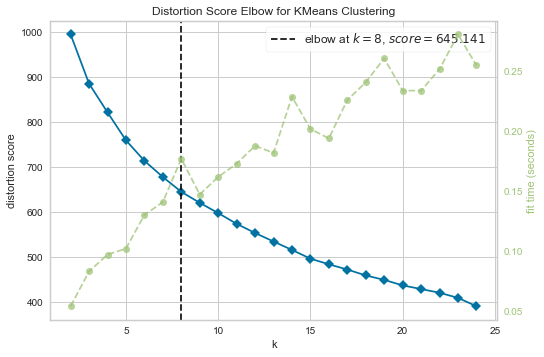

8 0.06468959292084696 0.5034248534248534
(0.3489417075271668, 0.1394511612429105, 0.19926714508870305)


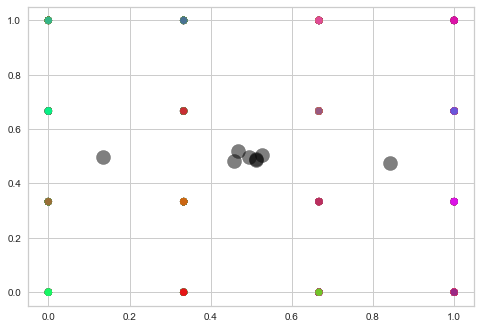

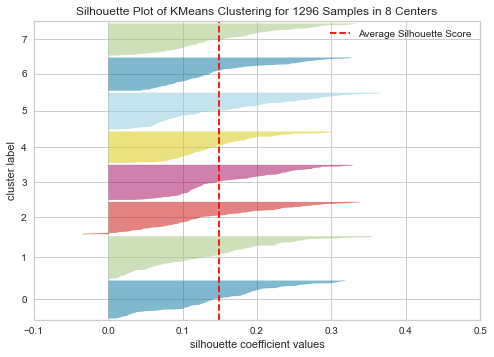

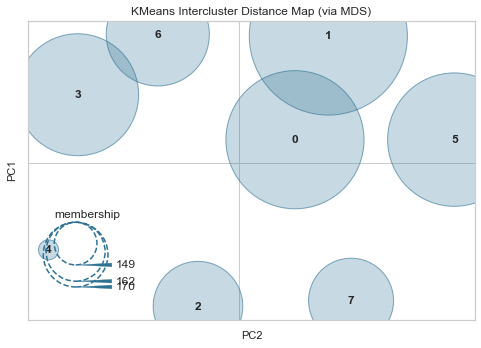

EM


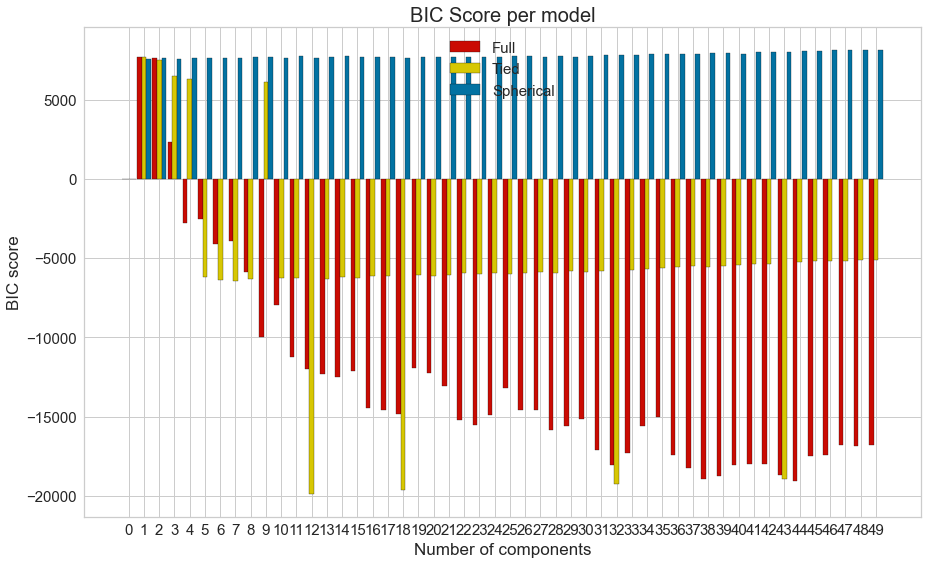

12 0.0828130796685364 0.5109621526288193
(0.4570788004520077, 0.1612817240760266, 0.23843196339794742)


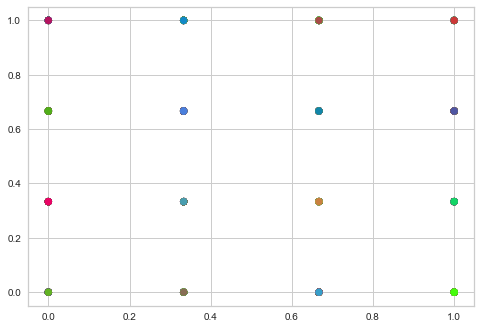

In [14]:
problem1(X_train, Y_train, 20)

PCA


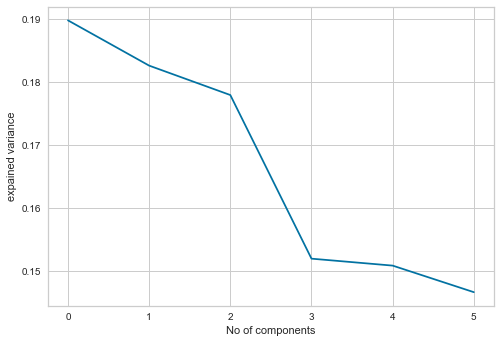

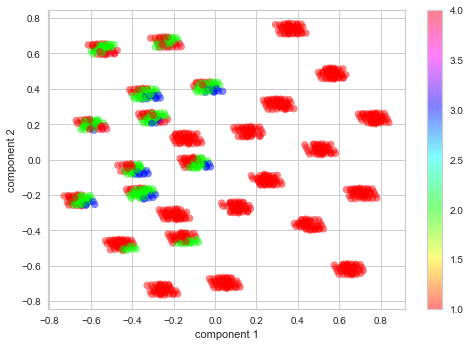

Loss: 0.5787582448725863
ICA


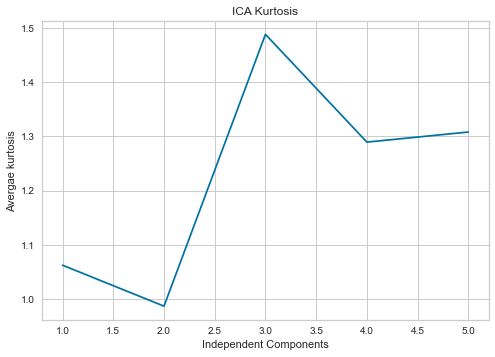

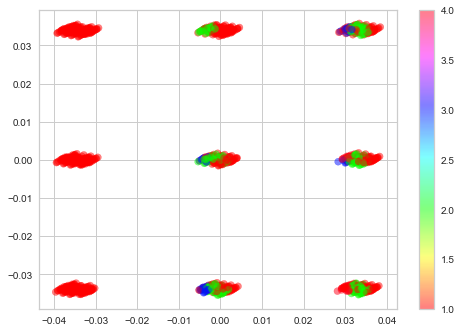

Loss: 0.414597371566715
RCA


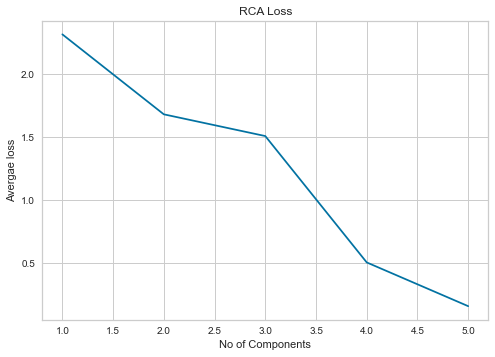

0.47516463548805987 0.21493137993557027


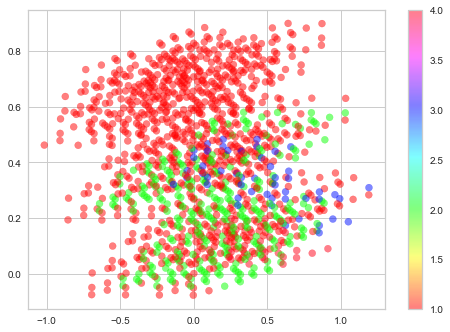

Loss: 0.15954797540263777
NMF


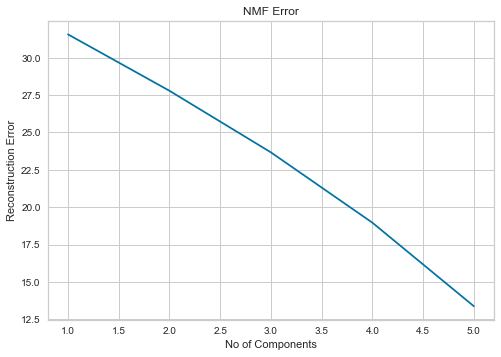

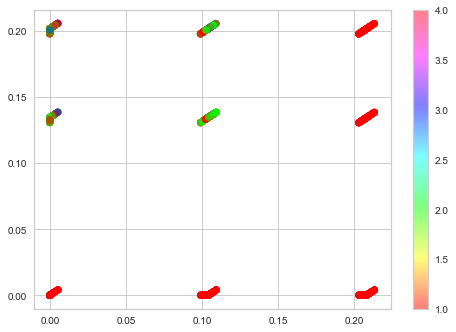

Loss: 0.1380949072441794


In [15]:
problem2(X_train, Y_train, 20)

PCA with clustering


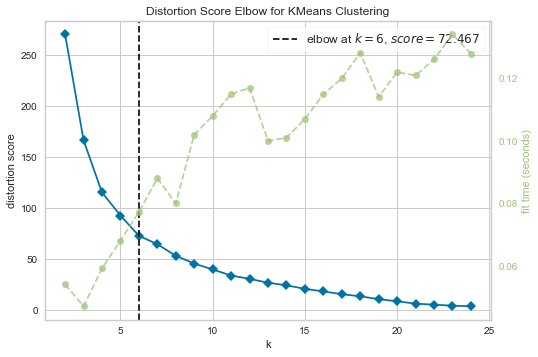

6 0.08011742265836135 0.5155381572048239
(0.3485003424018309, 0.16446869126092334, 0.2234731200421563)


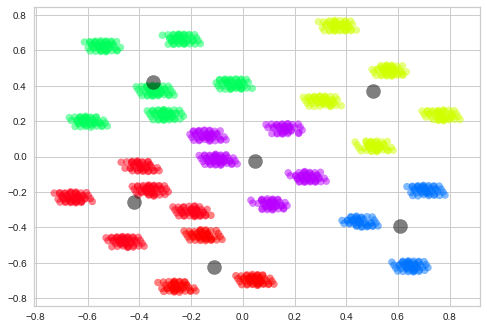

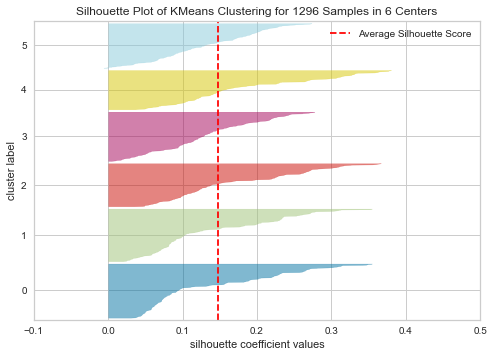

c:\users\ashok\appdata\local\programs\python\python39\lib\site-packages\sklearn\manifold\_mds.py:441: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


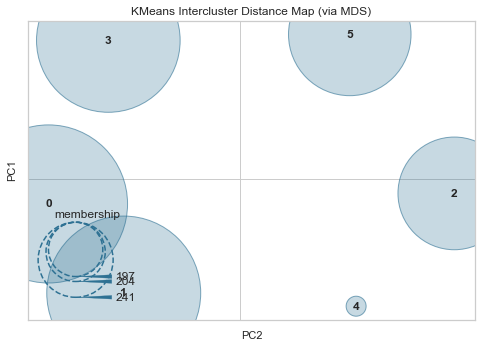

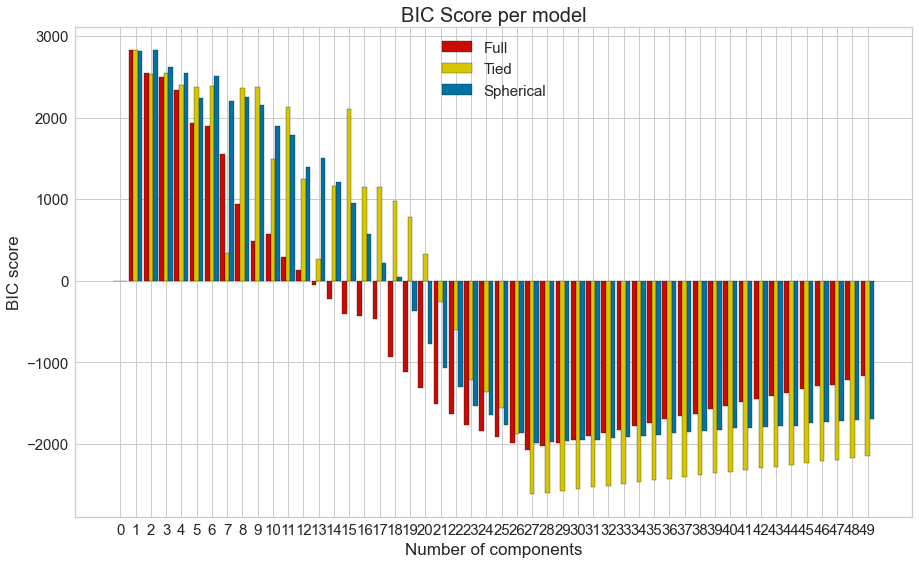

27 0.026974900816940477 0.47623695123695126
(0.49785888345248425, 0.12530799196862227, 0.20022147976659982)


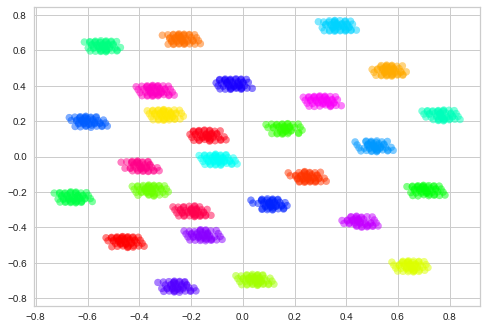

ICA with clustering


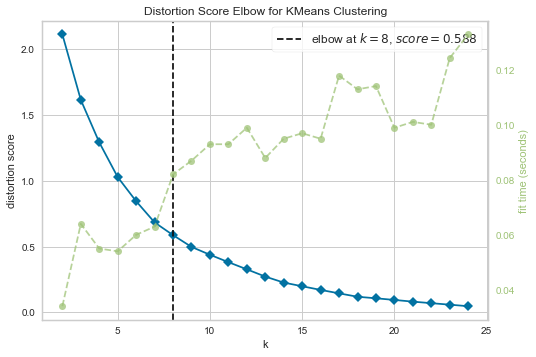

8 0.09396004380785258 0.5194754278087611
(0.4582644178117275, 0.1858540522713933, 0.26445538520610823)


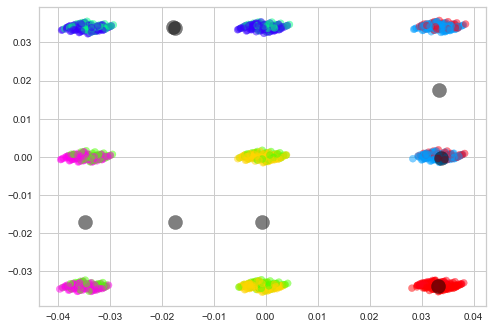

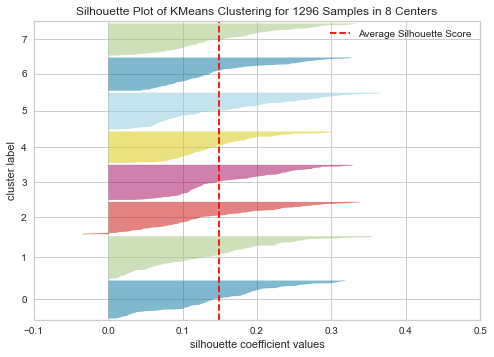

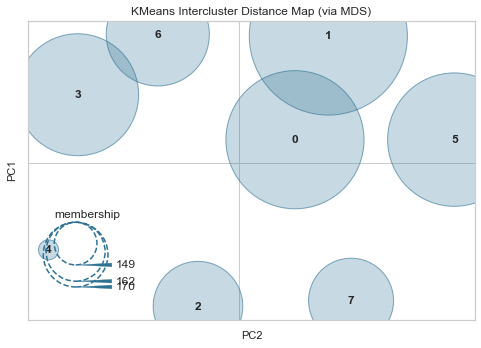

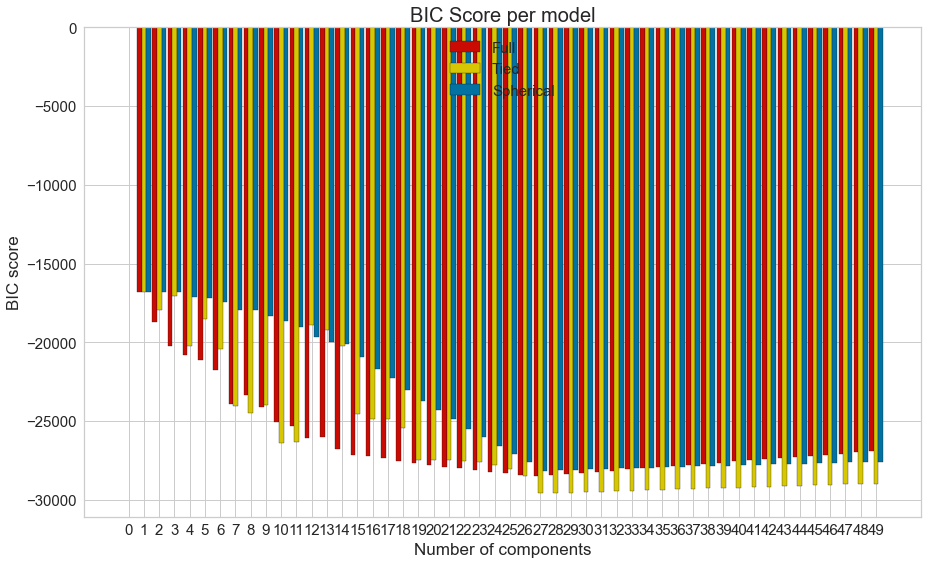

27 0.026974900816940477 0.47623695123695126
(0.4978588834524843, 0.12530799196862227, 0.2002214797665998)


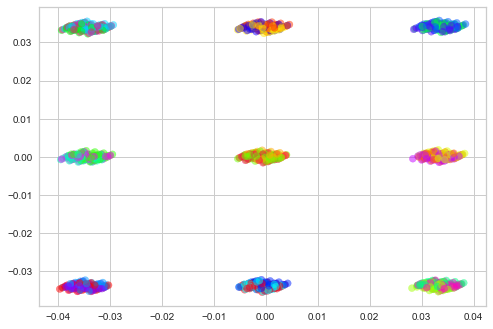

RCA with clustering


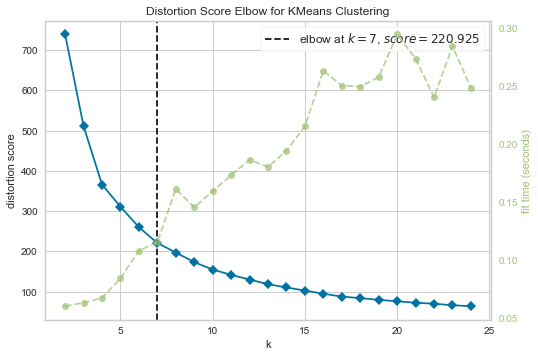

7 0.036387835598661704 0.49003408170074836
(0.20494676743856857, 0.08789292714684516, 0.12302547525165167)


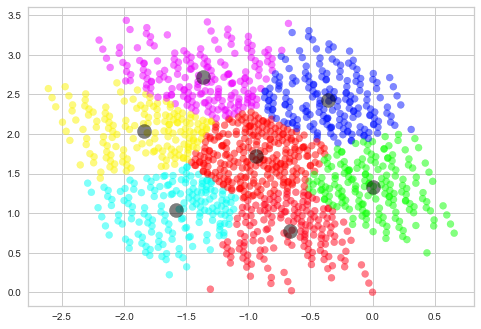

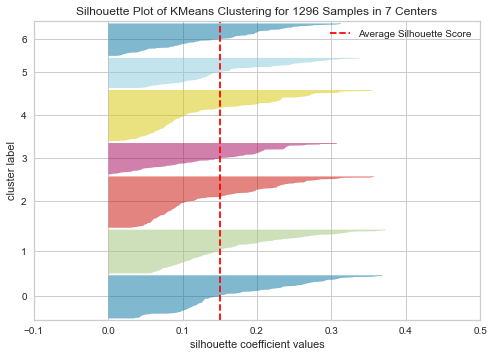

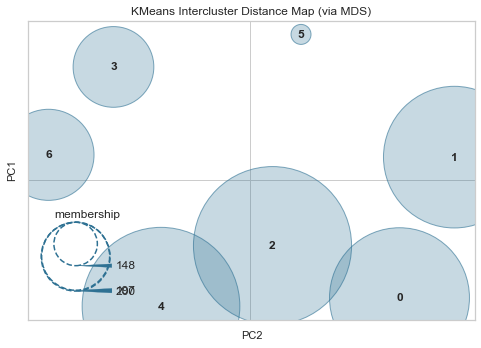

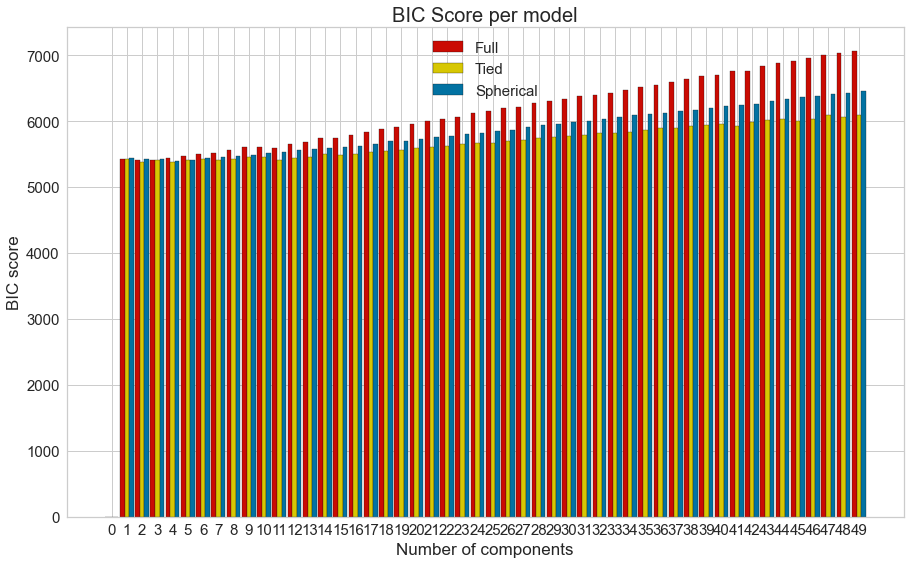

4 0.03996968596814535 0.5002002002002002
(0.12352270974121693, 0.07398151917973692, 0.0925387549398786)


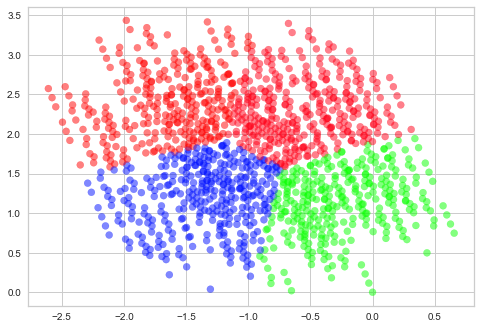

NMF with clustering


c:\users\ashok\appdata\local\programs\python\python39\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
c:\users\ashok\appdata\local\programs\python\python39\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
c:\users\ashok\appdata\local\programs\python\python39\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' valu

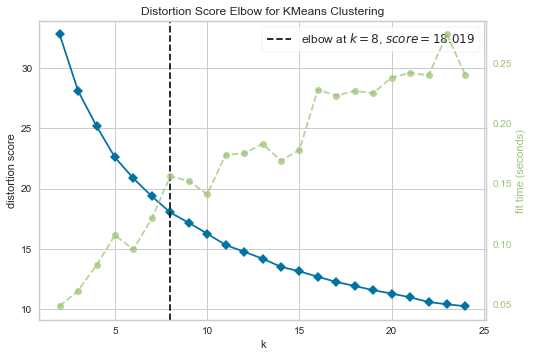

8 0.07766759800720097 0.5105069355069355
(0.4331924823600572, 0.1739951676146721, 0.24827052586063314)


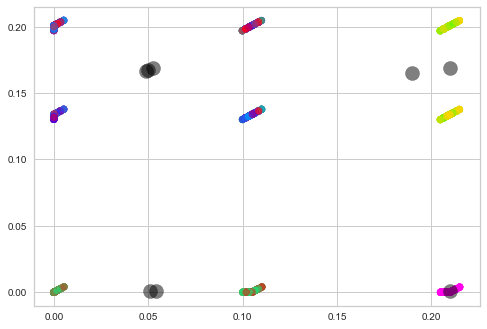

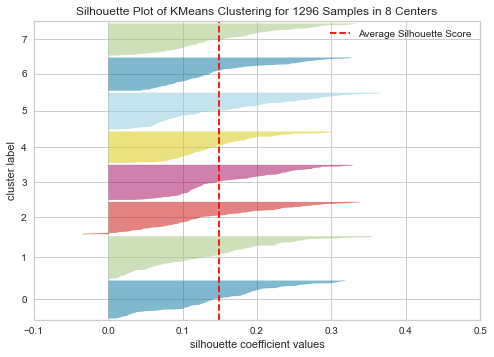

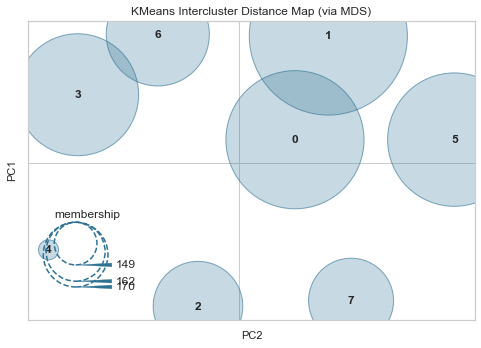

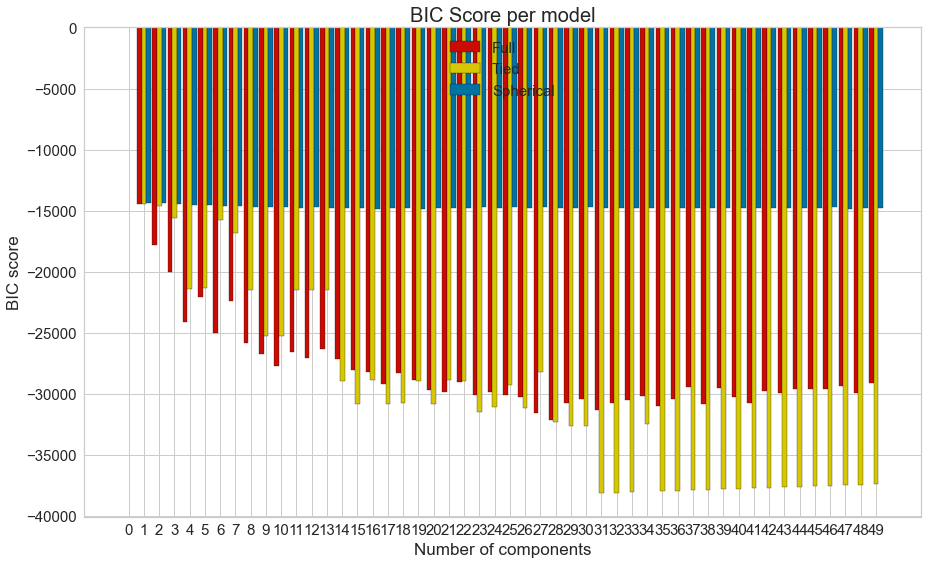

31 0.026291573785992603 0.47578173411506747
(0.5033487860413778, 0.12500222553864695, 0.2002693313698444)


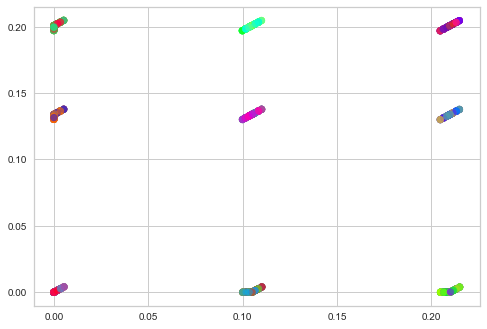

In [16]:
problem3(X_train, Y_train, 20)

PCA with Neural net


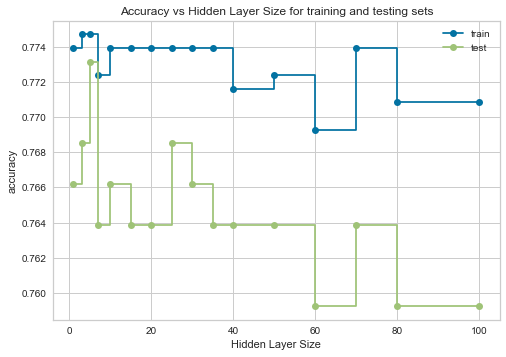

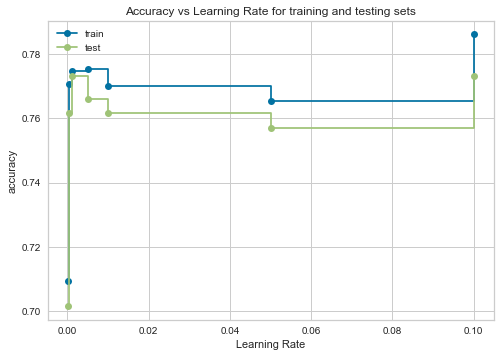

Hidden layer size: 5, Learning Rate: 0.005


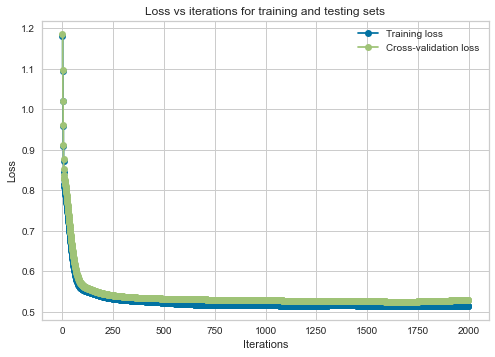

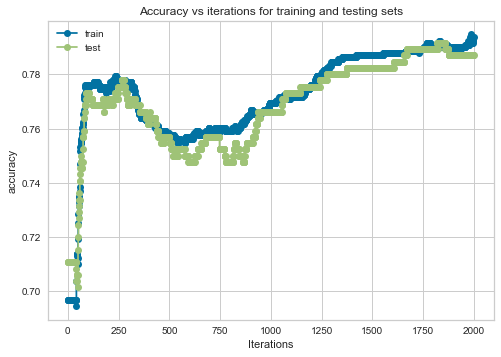

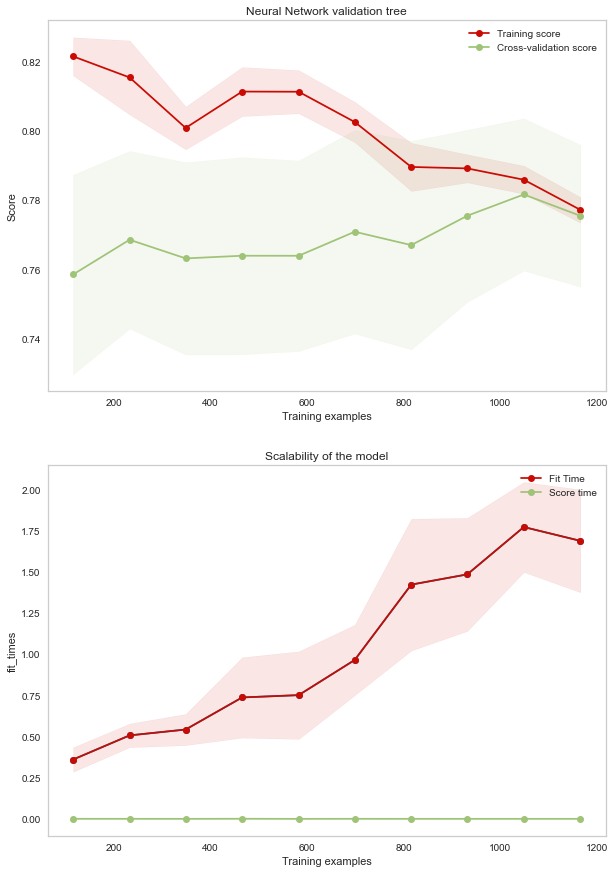

Accuracy score:  0.7662037037037037
ICA with Neural net


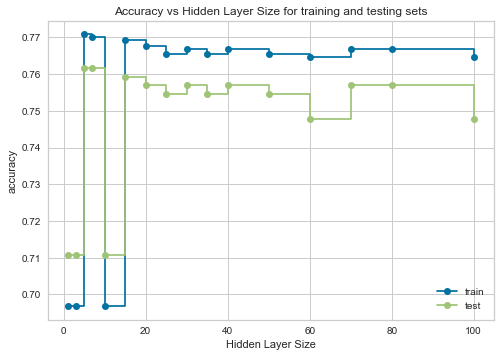

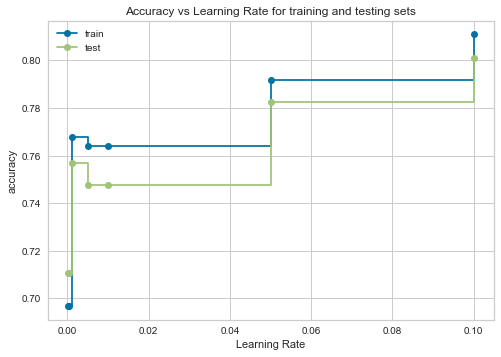

Hidden layer size: 20, Learning Rate: 0.1


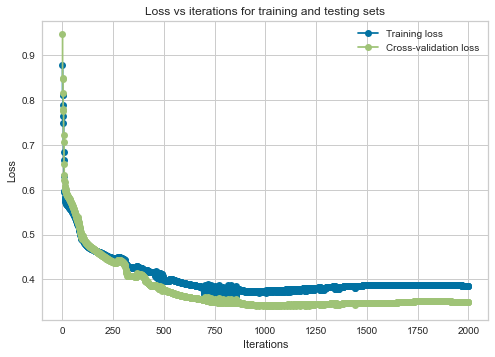

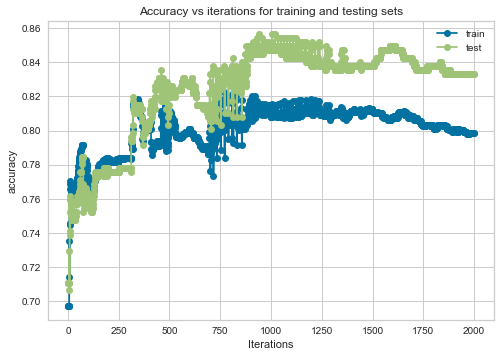

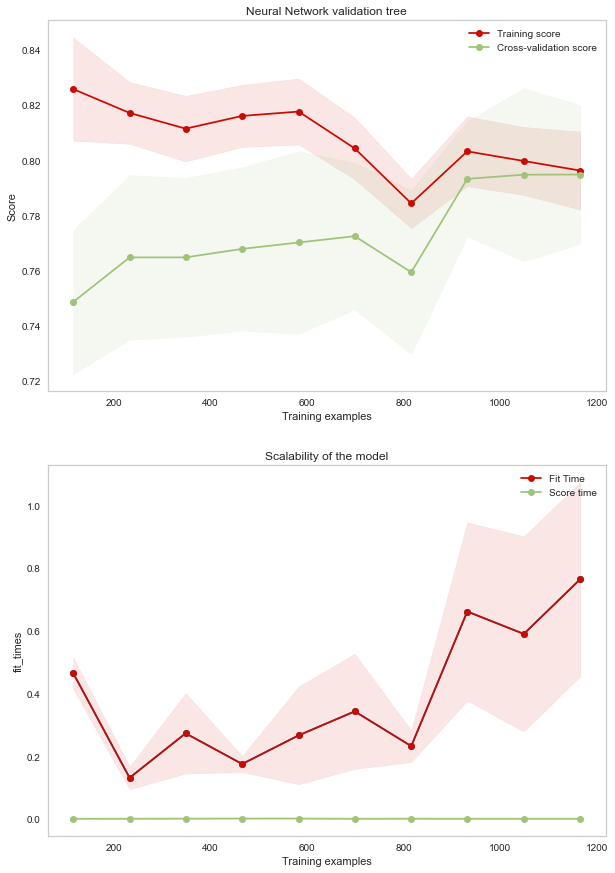

Accuracy score:  0.8009259259259259
RCA with Neural net


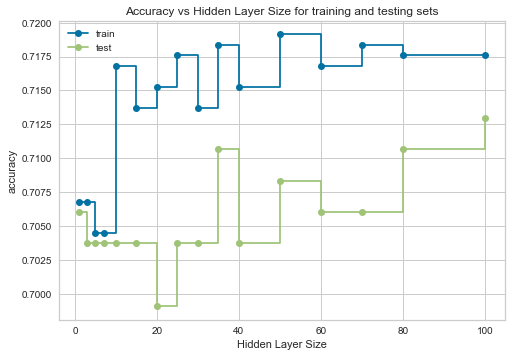

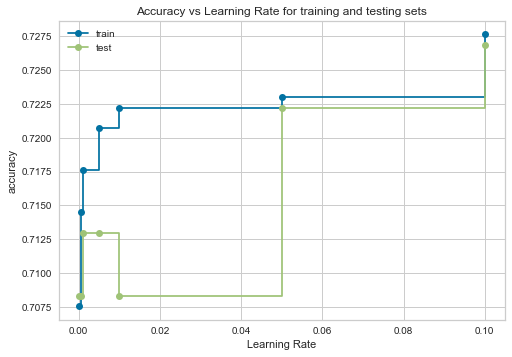

Hidden layer size: 100, Learning Rate: 0.05


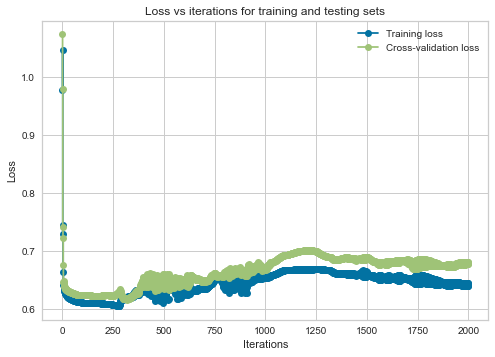

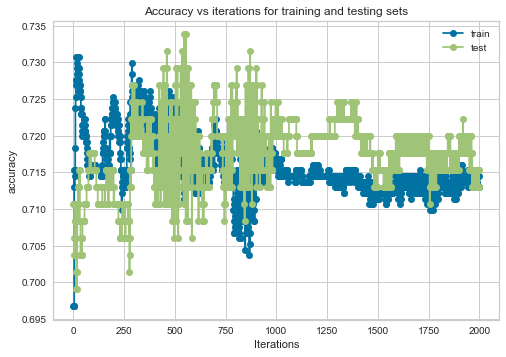

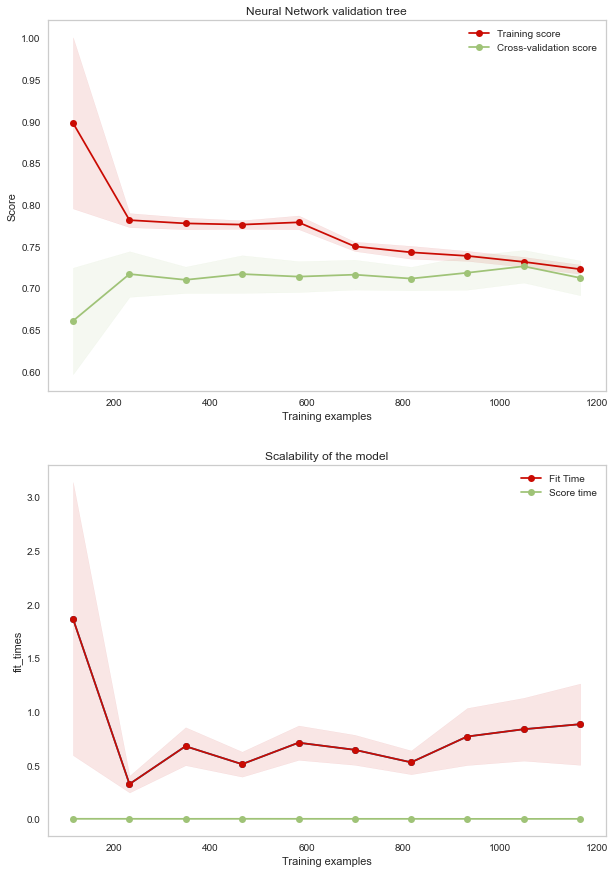

Accuracy score:  0.7222222222222222
NMF with Neural net


c:\users\ashok\appdata\local\programs\python\python39\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
c:\users\ashok\appdata\local\programs\python\python39\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
c:\users\ashok\appdata\local\programs\python\python39\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' valu

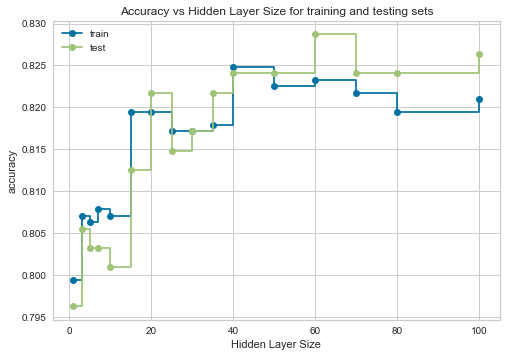

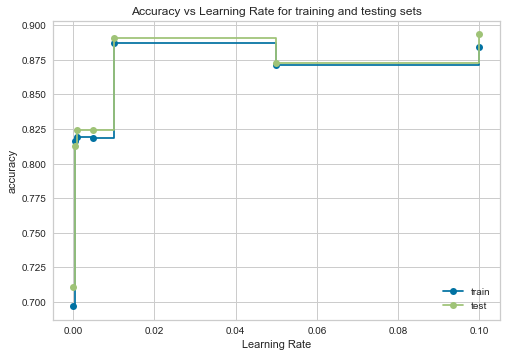

Hidden layer size: 80, Learning Rate: 0.1


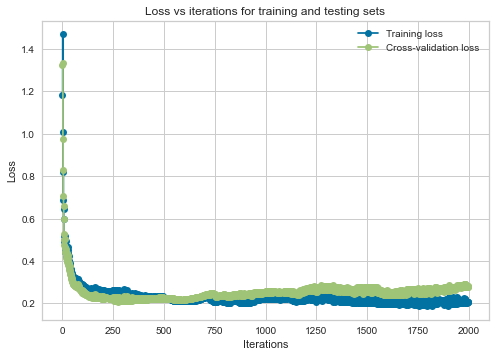

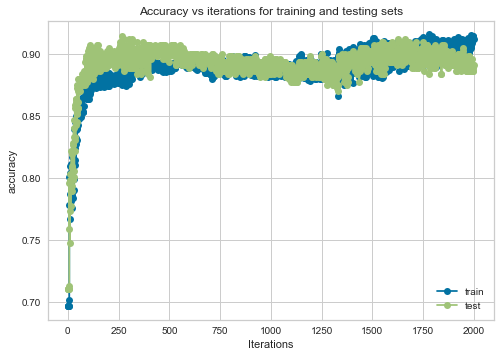

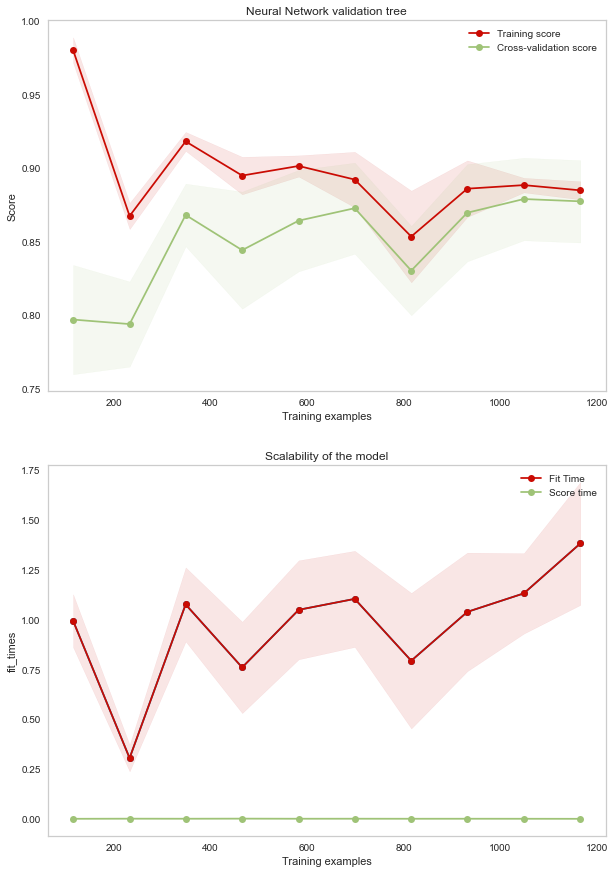

Accuracy score:  0.8935185185185185


In [16]:
problem4(X_train, X_test, Y_train, Y_test)

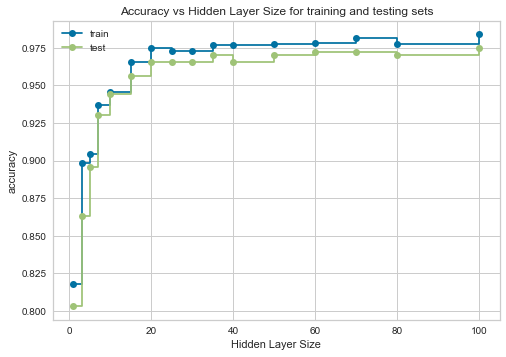

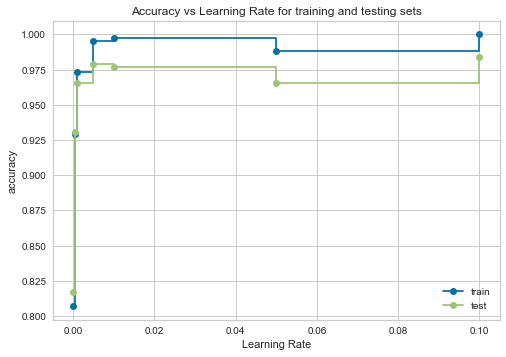

Hidden layer size: 30, Learning Rate: 0.1


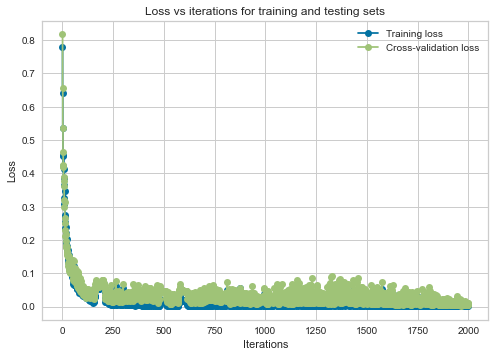

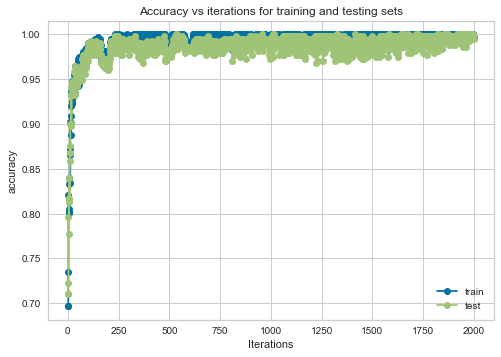

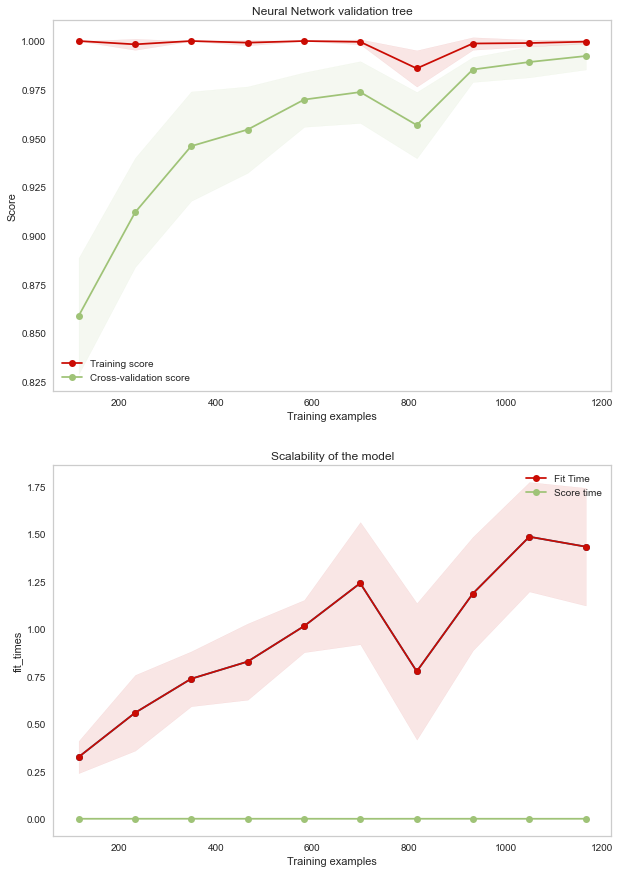

Accuracy score:  0.9837962962962963


In [14]:
classify_neural_network(X_train, X_test, Y_train, Y_test)

With Kmeans and NN


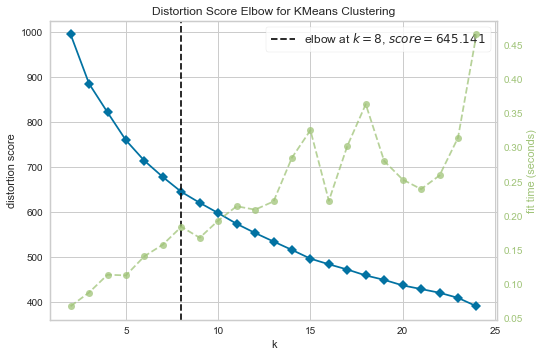

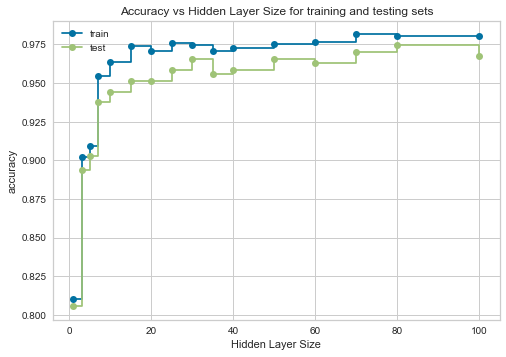

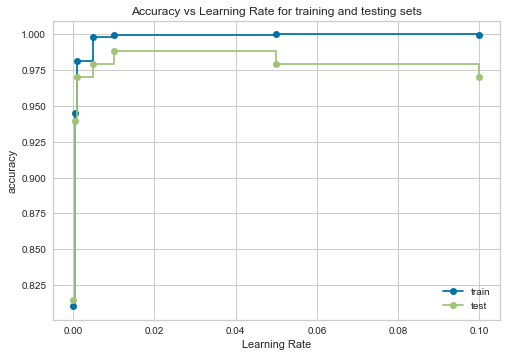

Hidden layer size: 70, Learning Rate: 0.1


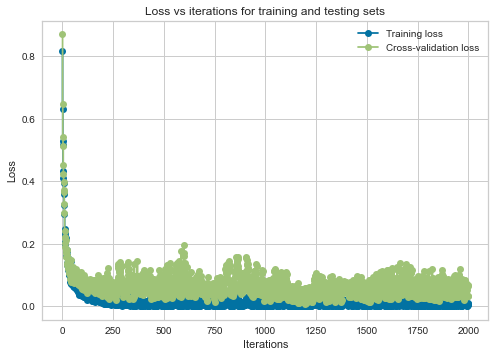

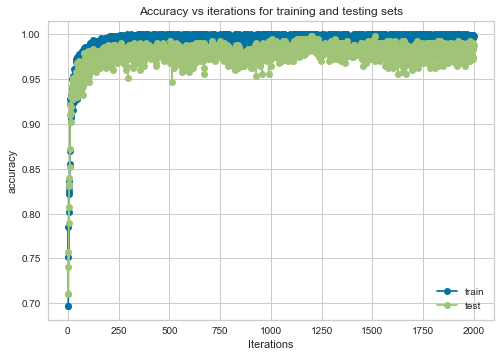

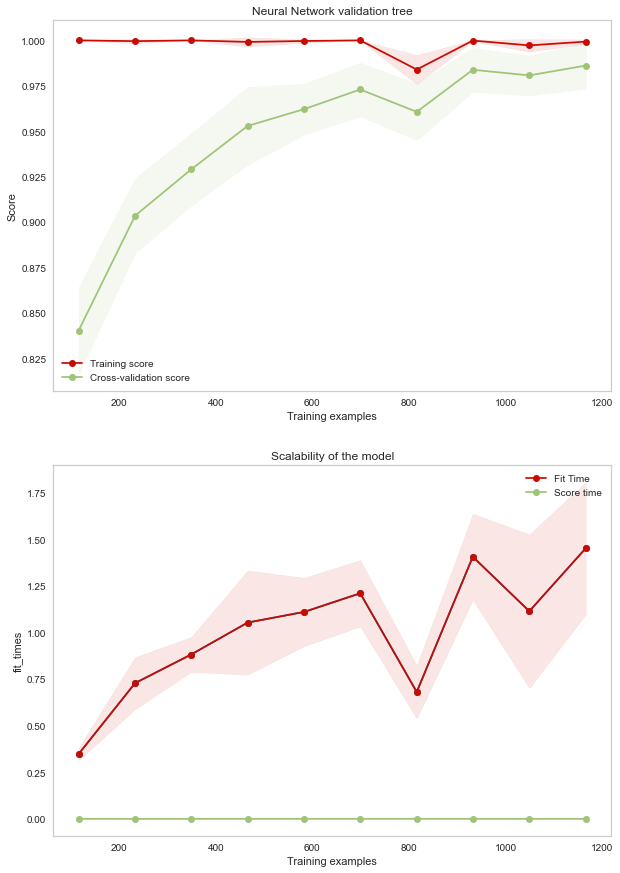

Accuracy score:  0.9699074074074074
With EM and NN


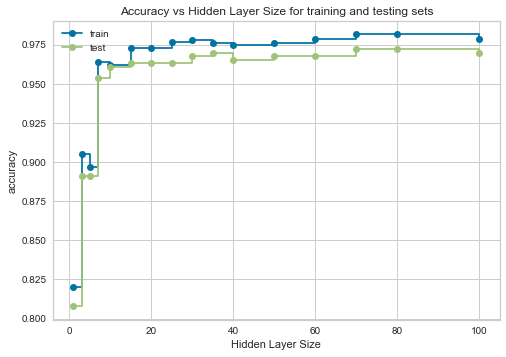

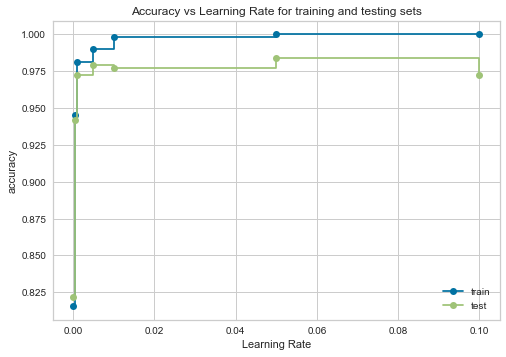

Hidden layer size: 70, Learning Rate: 0.05


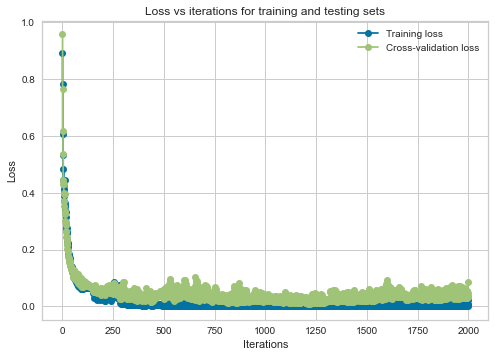

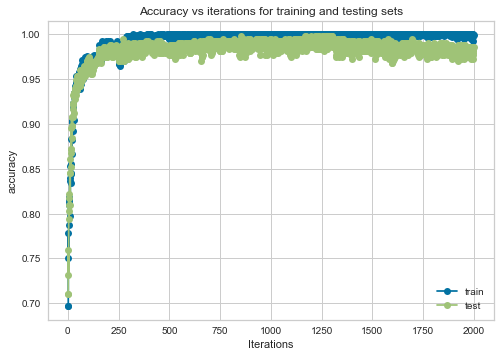

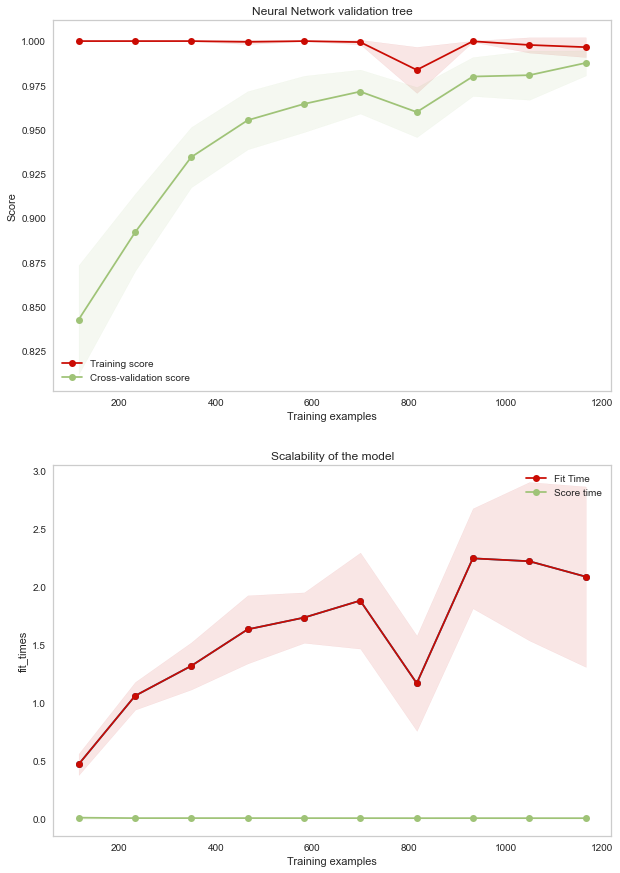

Accuracy score:  0.9837962962962963


In [24]:
problem5(X_train, X_test, Y_train, Y_test, 20)

In [17]:
def convert_obseity_data():
    df = pd.read_csv('ObesityDataSet_raw_and_data_sinthetic.csv', delimiter=',')
    df = df[['Gender', 'Age','Height', 'Weight', 'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', "CAEC", "SMOKE", "CH2O", "SCC", "FAF", "TUE", "CALC", "MTRANS", "NObeyesdad"]]
    data = df.fillna(method="ffill")
    def genderToInt(gender):
        if (gender == 'Male'):
            return 1
        else:
            return 2
        
    def convert_yes_no_to_int(value):
        if (value == 'yes'):
            return 1
        else:
            return 0
        
    def convert_some_to_int(value):
        if (value == 'no'):
            return 0
        elif (value == 'Sometimes'):
            return 1
        elif (value == 'Frequently'):
            return 2
        elif (value == 'Always'):
            return 3
        
    def convert_transport_to_int(value):
        if (value == 'Walking'):
            return 0
        elif (value == 'Bike'):
            return 1
        elif (value == 'Public_Transportation'):
            return 2
        elif (value == 'Automobile'):
            return 3
        elif (value == 'Motorbike'):
            return 4
    
    def convert_obese_to_int(value):
        if (value == 'Insufficient_Weight'):
            return 0
        elif (value == 'Normal_Weight'):
            return 1
        elif (value == 'Overweight_Level_I'):
            return 2
        elif (value == 'Overweight_Level_II'):
            return 3
        elif (value == 'Obesity_Type_I'):
            return 4
        elif (value == 'Obesity_Type_II'):
            return 5
        elif (value == 'Obesity_Type_III'):
            return 6
        
    data['Gender'] = data['Gender'].transform(lambda x: genderToInt(x))
    data['Age'] = pd.cut(data['Age'].astype(float), bins=10, labels=np.arange(10))
    data['Height'] = pd.cut(data['Height'].astype(float), bins=10, labels=np.arange(10))
    data['Weight'] = pd.cut(data['Weight'].astype(float), bins=10, labels=np.arange(10))
    data['FCVC'] = pd.cut(data['FCVC'].astype(float), bins=8, labels=np.arange(8))
    data['NCP'] = pd.cut(data['NCP'].astype(float), bins=10, labels=np.arange(10))
    data['CH2O'] = pd.cut(data['CH2O'].astype(float), bins=8, labels=np.arange(8))
    data['FAF'] = pd.cut(data['FAF'].astype(float), bins=8, labels=np.arange(8))
    data['TUE'] = pd.cut(data['TUE'].astype(float), bins=8, labels=np.arange(8))
    data['family_history_with_overweight'] = data['family_history_with_overweight'].transform(lambda x: convert_yes_no_to_int(x))
    data['FAVC'] = data['FAVC'].transform(lambda x: convert_yes_no_to_int(x))
    data['CAEC'] = data['CAEC'].transform(lambda x: convert_some_to_int(x))
    data['SMOKE'] = data['SMOKE'].transform(lambda x: convert_yes_no_to_int(x))
    data['SCC'] = data['SCC'].transform(lambda x: convert_yes_no_to_int(x))
    data['CALC'] = data['CALC'].transform(lambda x: convert_some_to_int(x))
    data['MTRANS'] = data['MTRANS'].transform(lambda x: convert_transport_to_int(x))
    data['NObeyesdad'] = data['NObeyesdad'].transform(lambda x: convert_obese_to_int(x))
                           
    X = data[['Gender', 'Age','Height', 'Weight', 'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', "CAEC", "SMOKE", "CH2O", "SCC", "FAF", "TUE", "CALC", "MTRANS"]]
    y = data[['NObeyesdad']].values.ravel()
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, y, stratify=y, random_state=random_state, shuffle=True)
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Neural Network
    return X_train_scaled, X_test_scaled, Y_train, Y_test

X_train_2, X_test_2, Y_train_2, Y_test_2 = convert_obseity_data()

K means


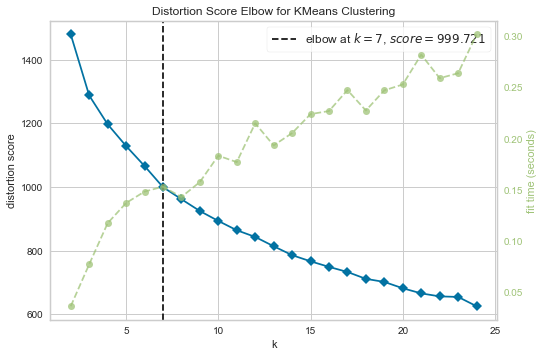

7 0.17760582975038403 0.7812367977395733
(0.24695929264117739, 0.2606736284603367, 0.25363120561639174)


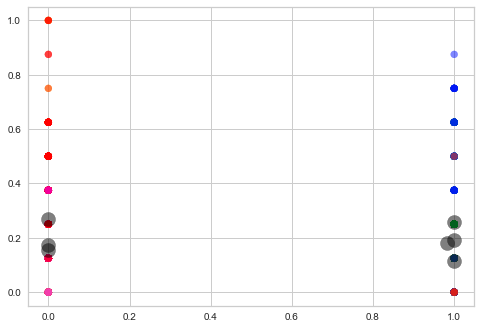

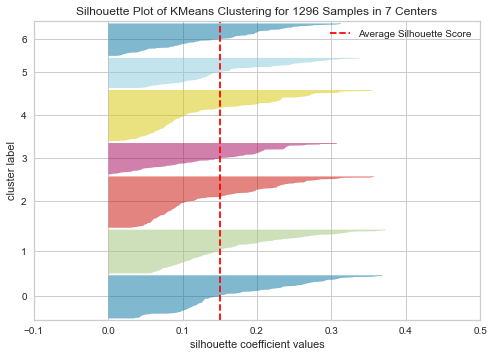

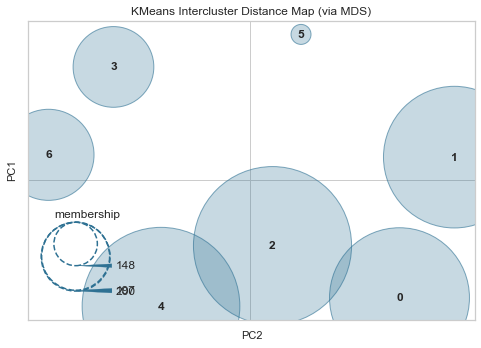

EM


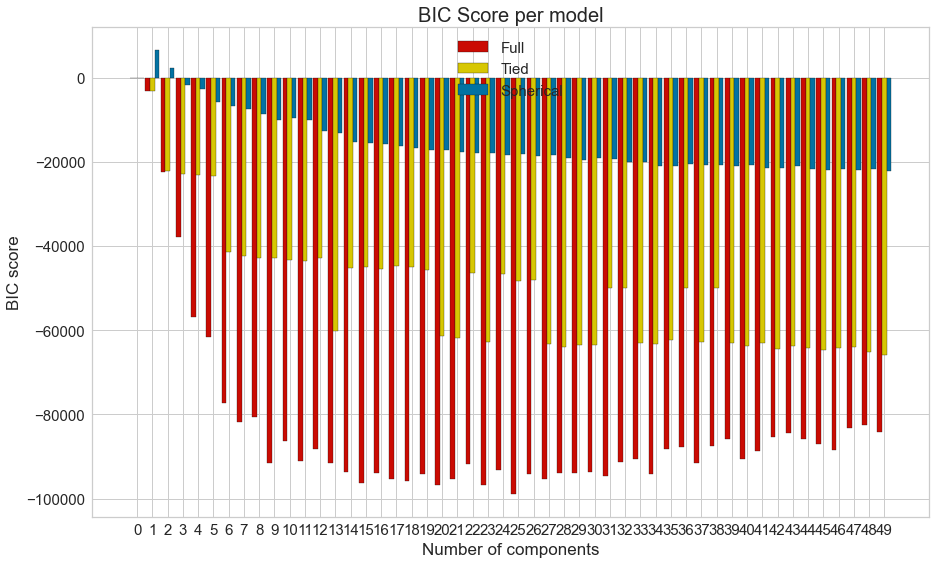

25 0.212523475881233 0.8321842458549394
(0.43444160451854213, 0.31590797319810754, 0.3658123382278039)


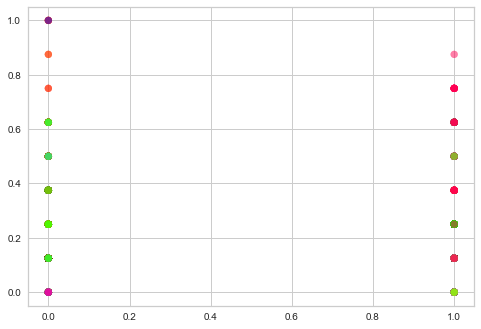

In [21]:
problem1(X_train_2, Y_train_2, 100)

PCA


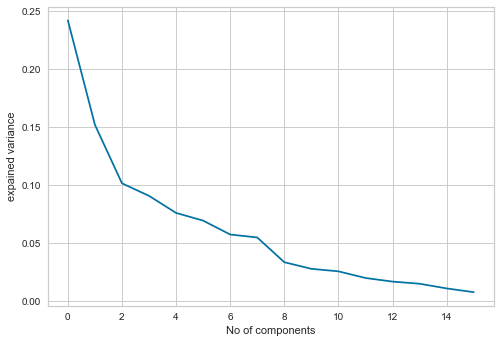

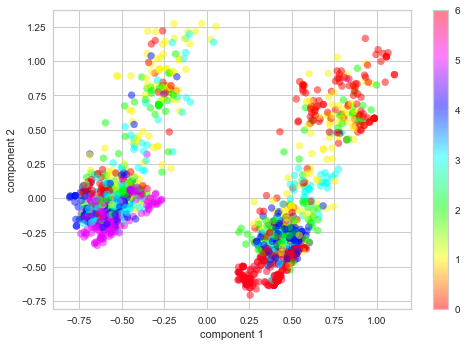

Loss: 0.7359211649122787
ICA


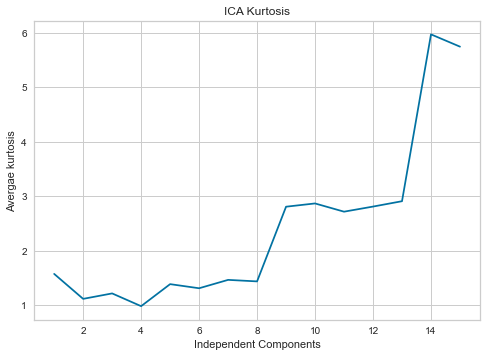

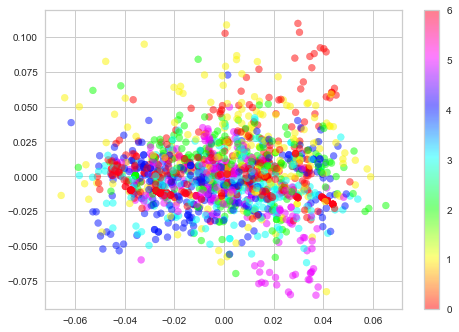

Loss: 0.022651827343519247
RCA


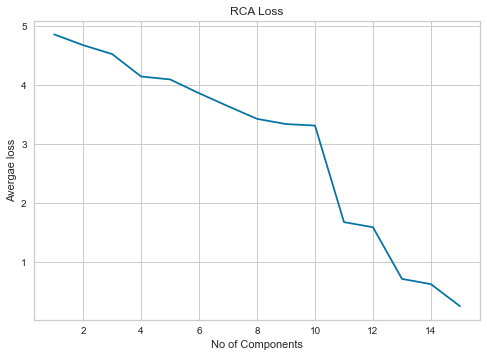

0.33348825766681567 0.288973625670551


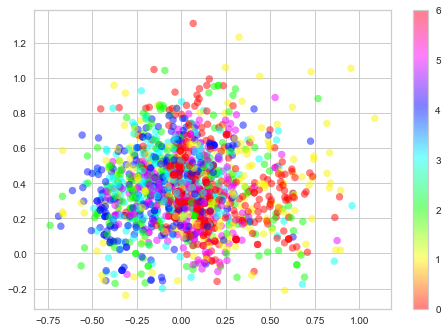

Loss: 0.06414541579417372
NMF


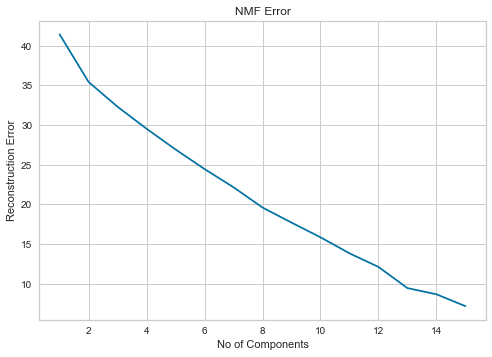

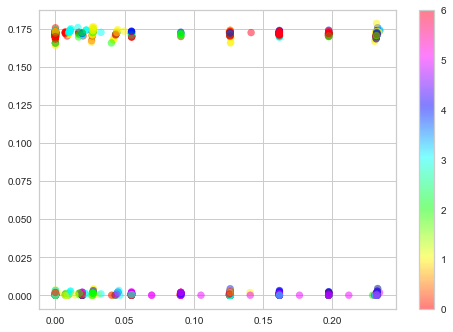

Loss: 0.032359092004325


In [22]:
problem2(X_train_2, Y_train_2, 100)

PCA with clustering


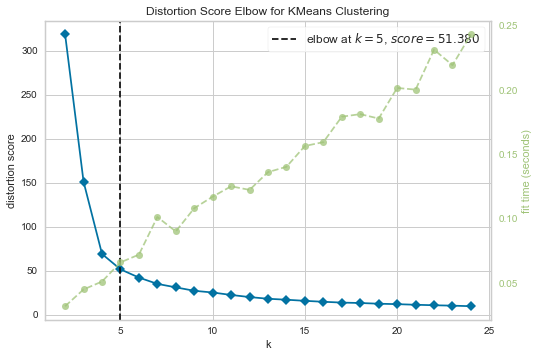

5 0.2162097674441903 0.7381206609735391
(0.2717678513504211, 0.3629983067113649, 0.3108271246218088)


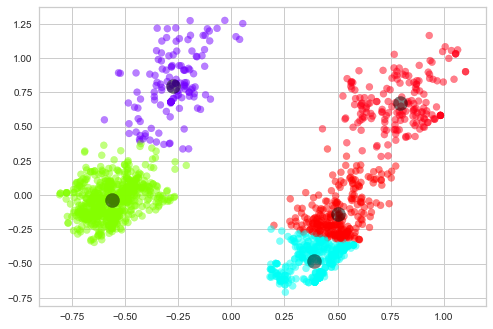

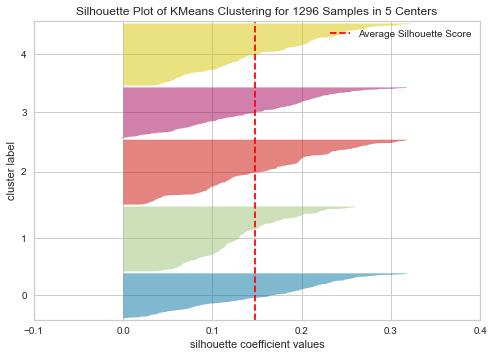

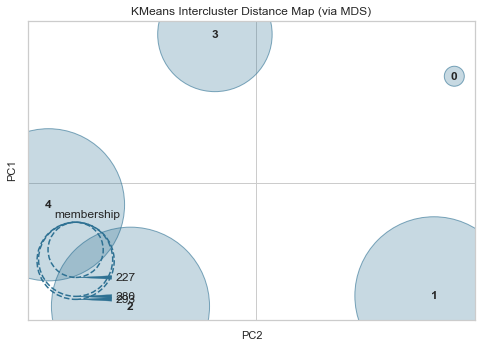

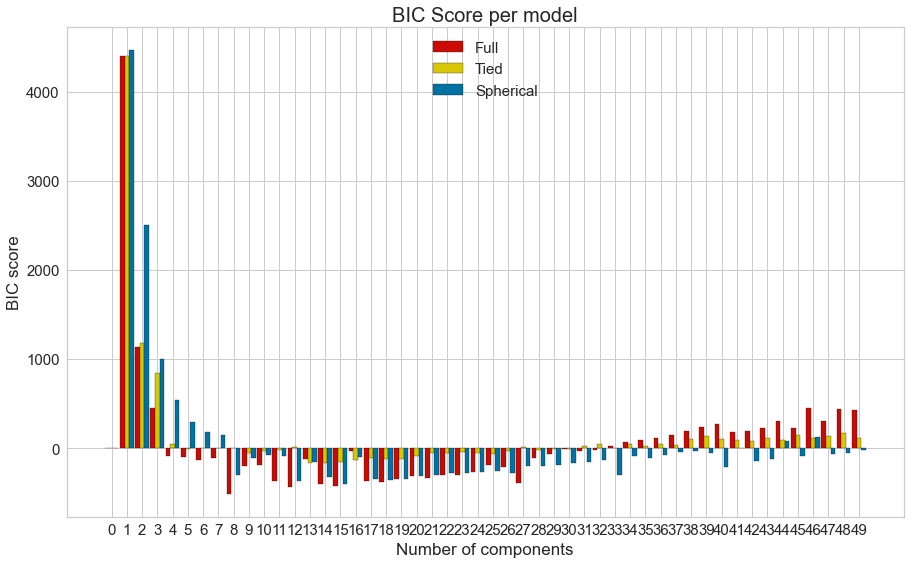

8 0.16760217956867418 0.7760369539505156
(0.3009532760178864, 0.312848985000814, 0.3067858589461829)


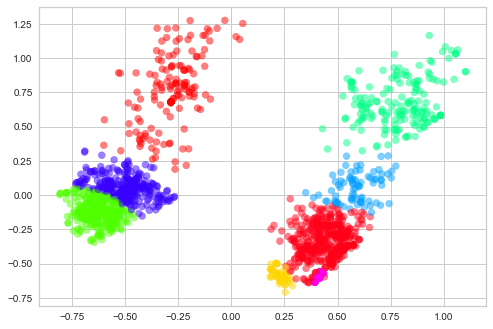

ICA with clustering


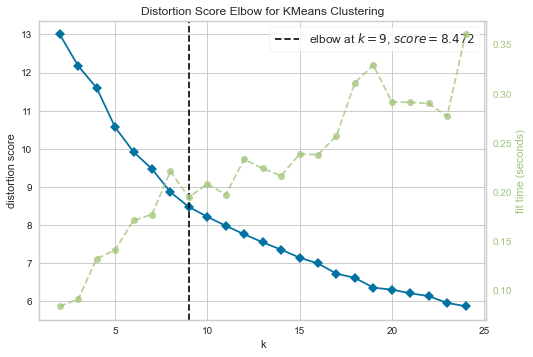

9 0.2436029674680431 0.8129797237238581
(0.3267439838292581, 0.31213412398345686, 0.31927200482289086)


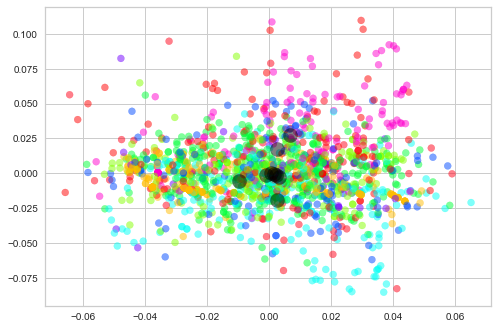

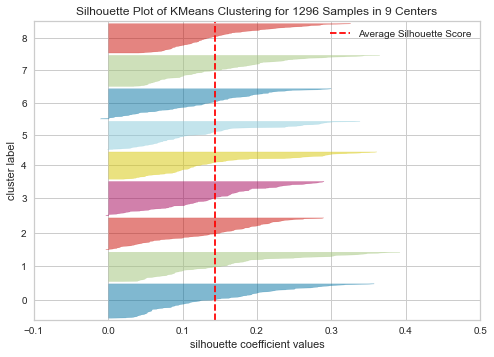

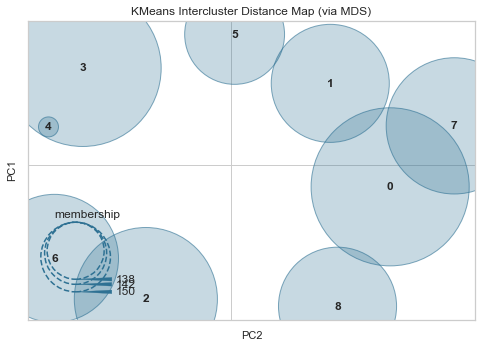

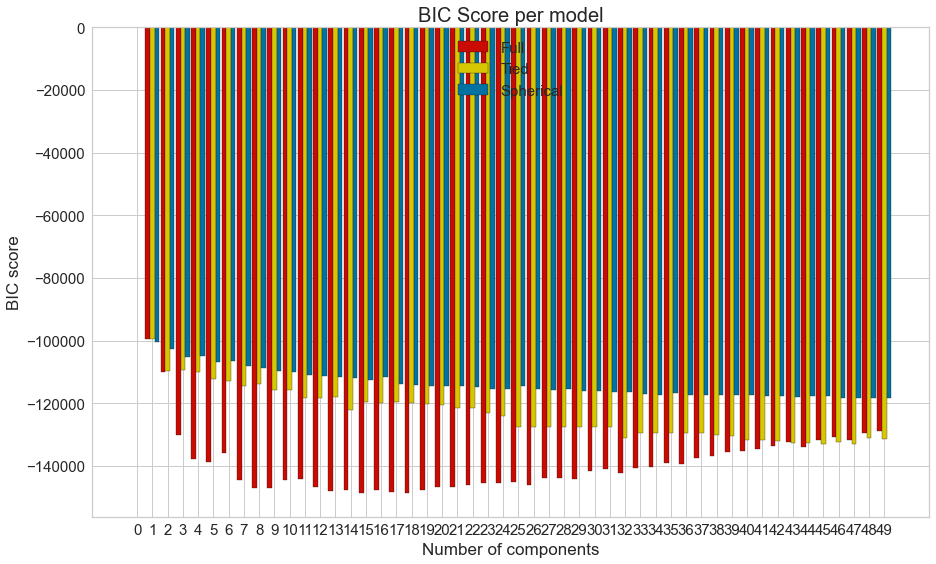

18 0.23023702589272788 0.8458966276485381
(0.45193926391954337, 0.3251877744178235, 0.3782267664253501)


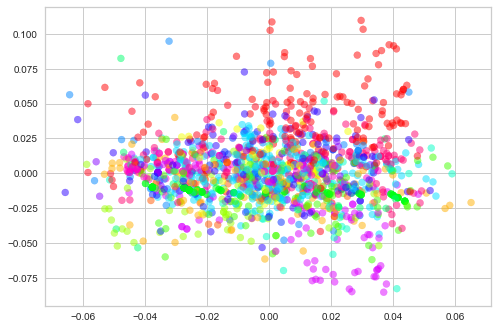

RCA with clustering


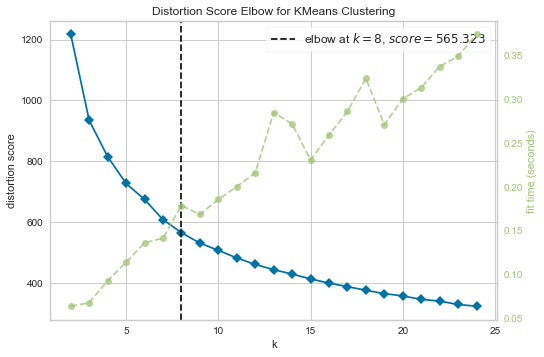

8 0.09932371573106193 0.7741242483945652
(0.19046923760364076, 0.18617862789320894, 0.18829949436263582)


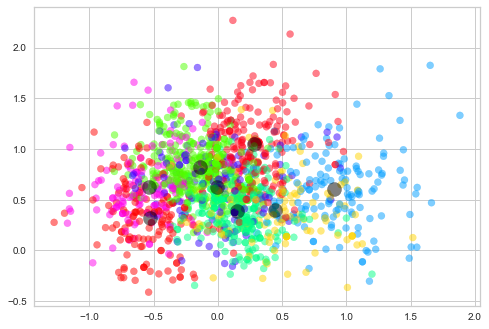

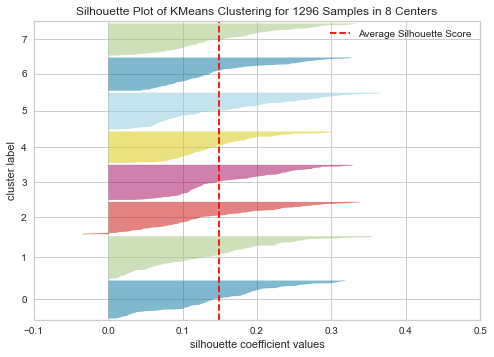

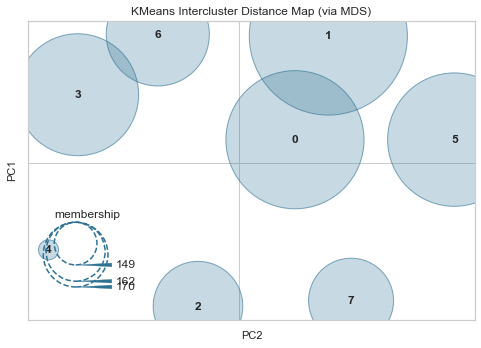

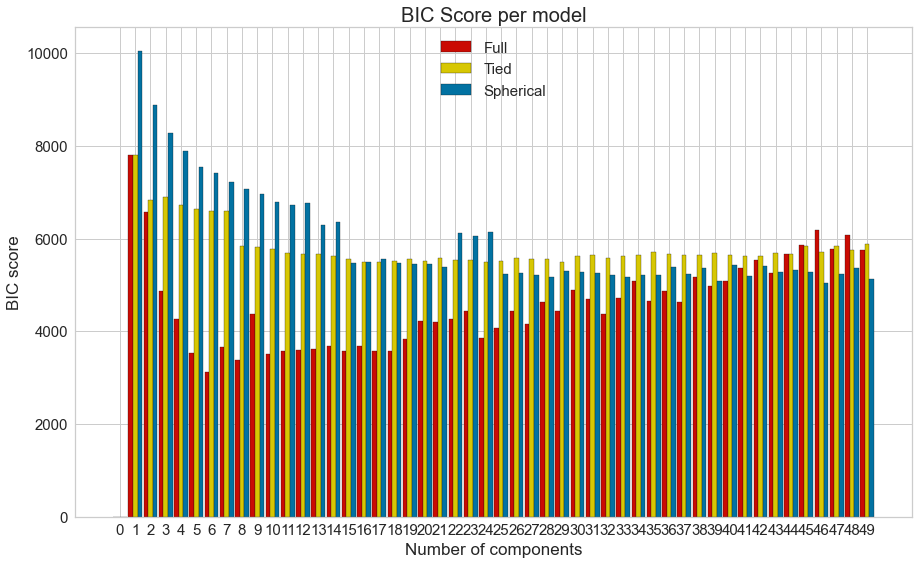

6 0.2122171532198955 0.7615818514191157
(0.3303858705587539, 0.39333737515129036, 0.35912377247232774)


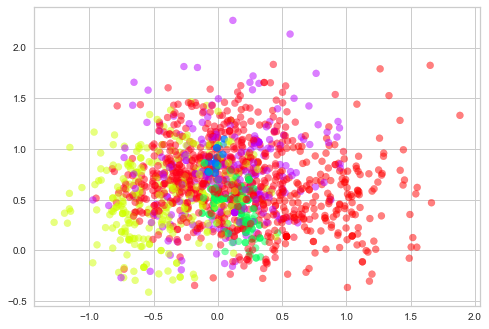

NMF with clustering


c:\users\ashok\appdata\local\programs\python\python39\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
c:\users\ashok\appdata\local\programs\python\python39\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
c:\users\ashok\appdata\local\programs\python\python39\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' valu

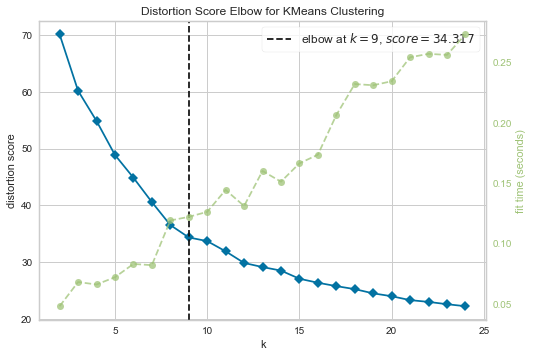

9 0.15456520663658693 0.7964713577334399
(0.24598502218742735, 0.23229353868956507, 0.23894331020722712)


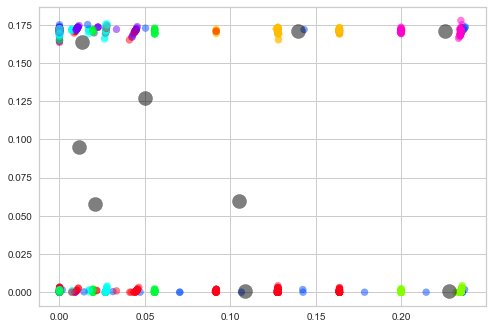

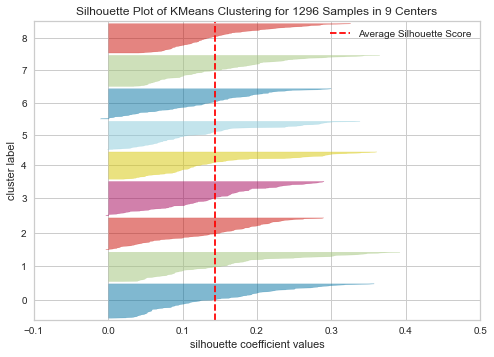

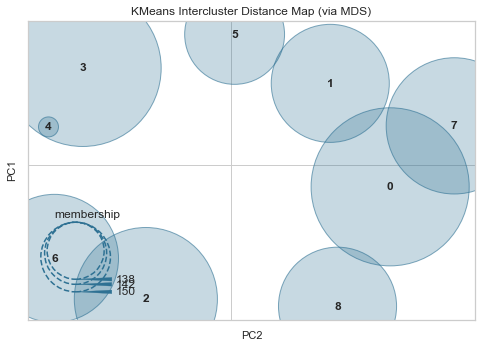

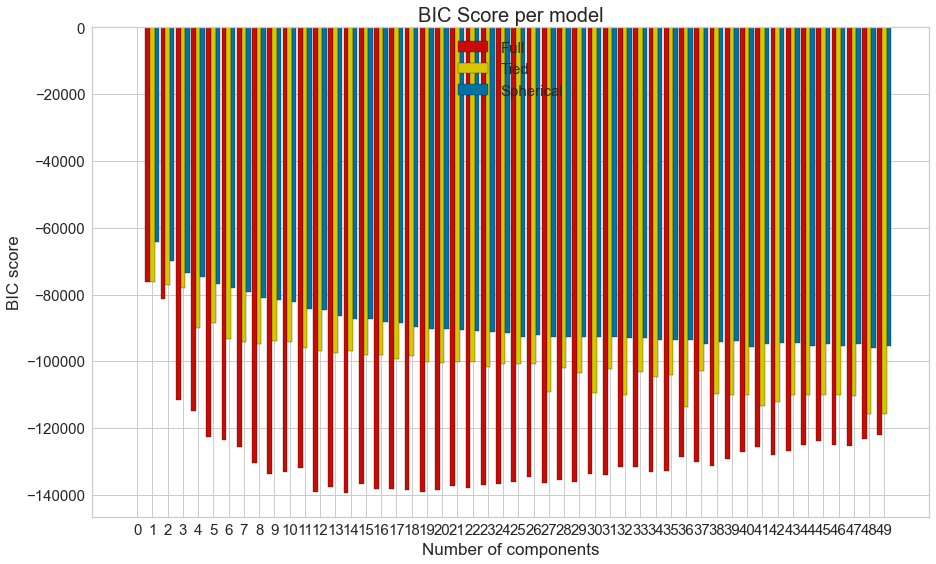

14 0.17845973079899793 0.8288771420106009
(0.34763813126981796, 0.26902893004934275, 0.30332320425808396)


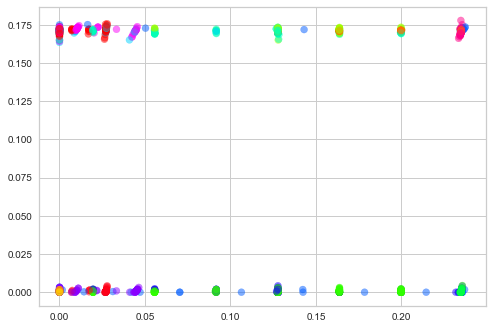

In [23]:
problem3(X_train_2, Y_train_2, 100)

PCA with Neural net


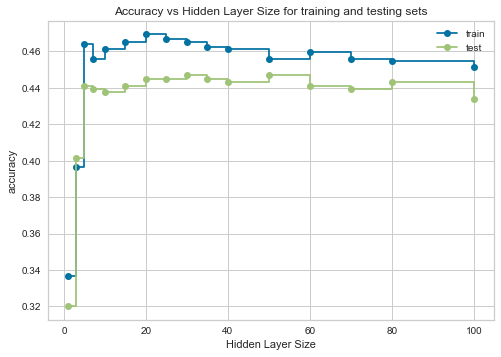

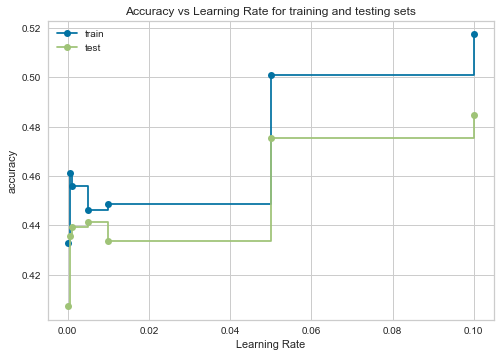

Hidden layer size: 70, Learning Rate: 0.1


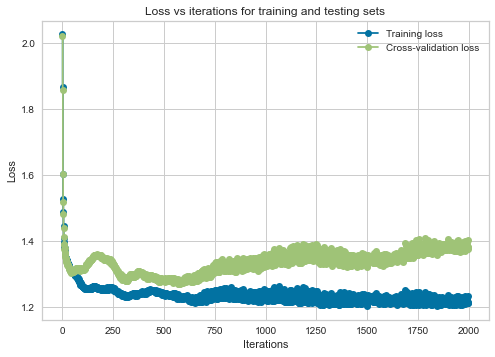

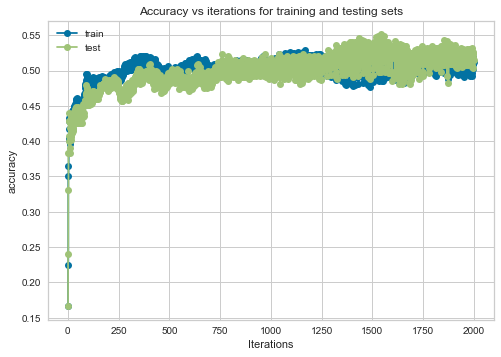

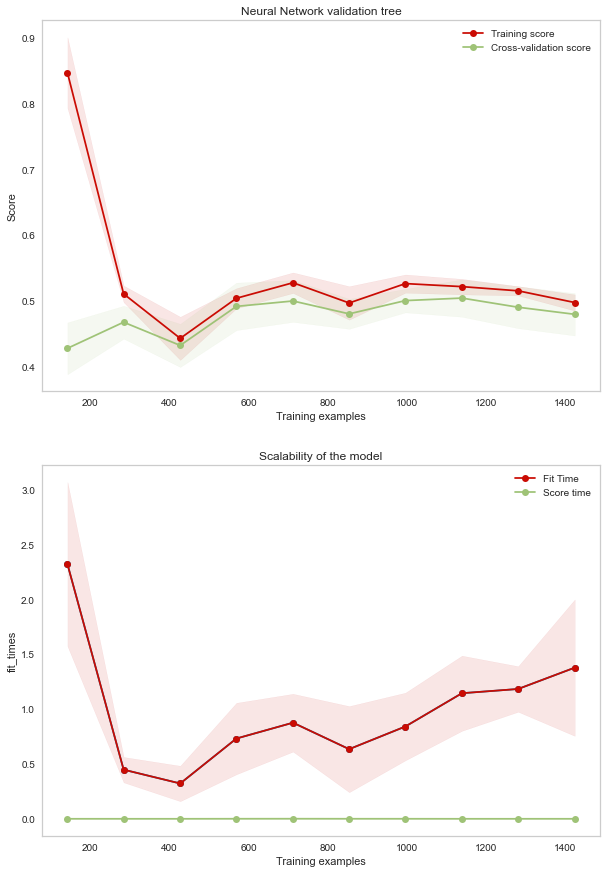

Accuracy score:  0.48484848484848486
ICA with Neural net


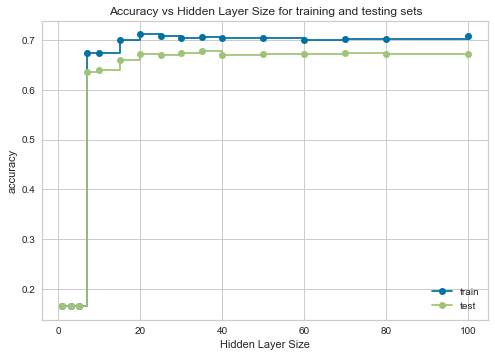

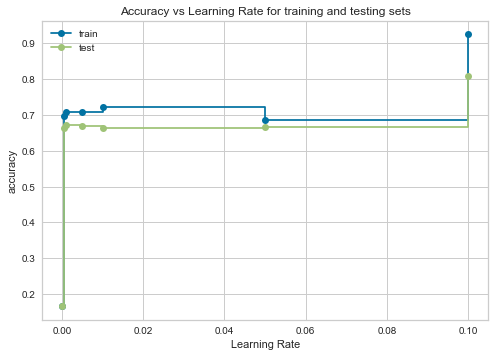

Hidden layer size: 100, Learning Rate: 0.1


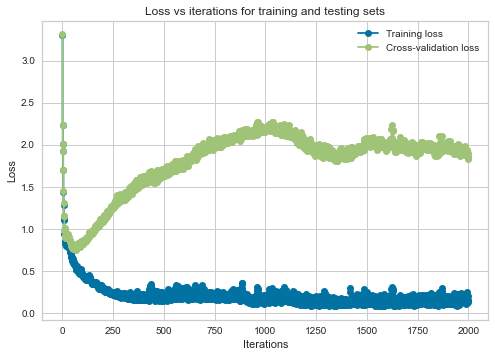

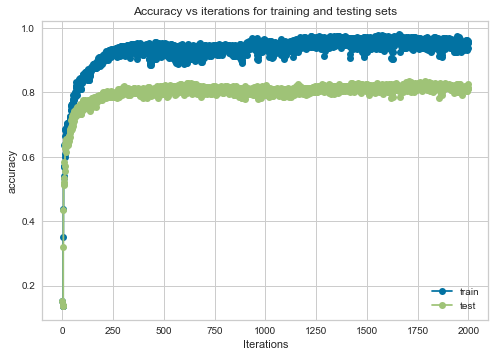

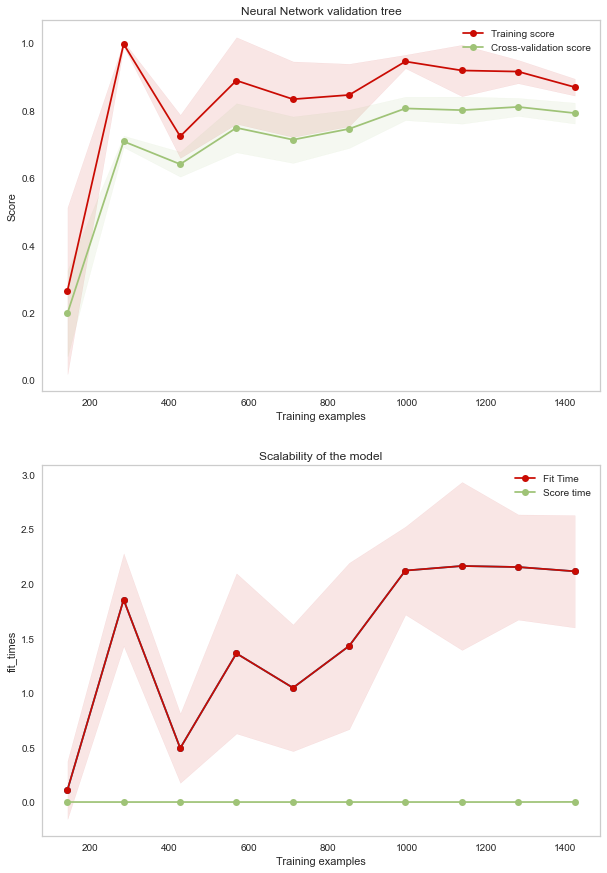

Accuracy score:  0.8087121212121212
RCA with Neural net


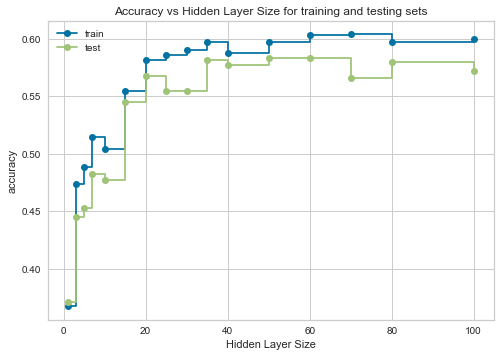

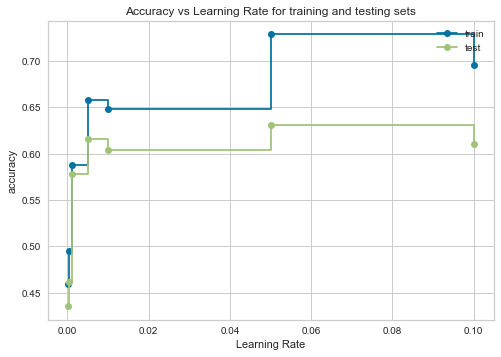

Hidden layer size: 40, Learning Rate: 0.05


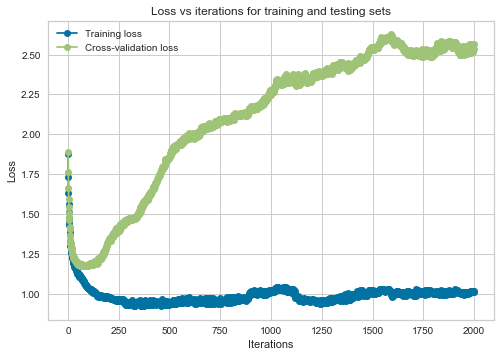

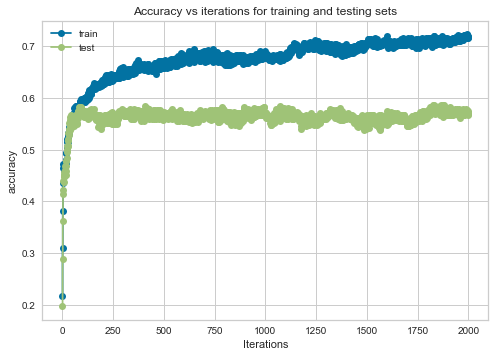

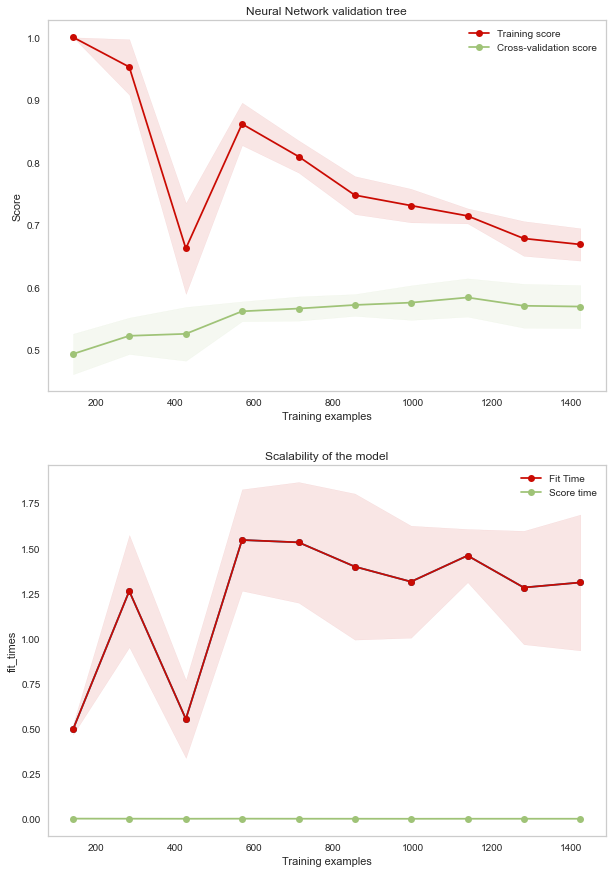

Accuracy score:  0.6306818181818182
NMF with Neural net


c:\users\ashok\appdata\local\programs\python\python39\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
c:\users\ashok\appdata\local\programs\python\python39\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
c:\users\ashok\appdata\local\programs\python\python39\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' valu

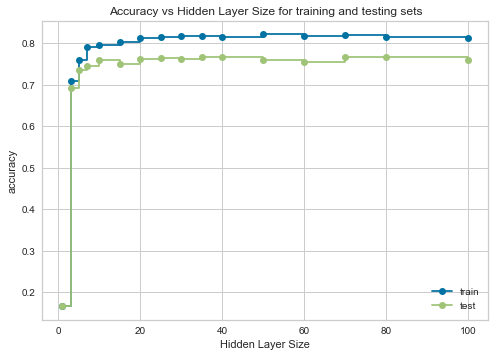

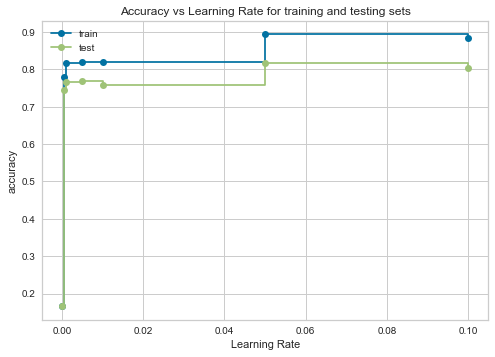

Hidden layer size: 35, Learning Rate: 0.1


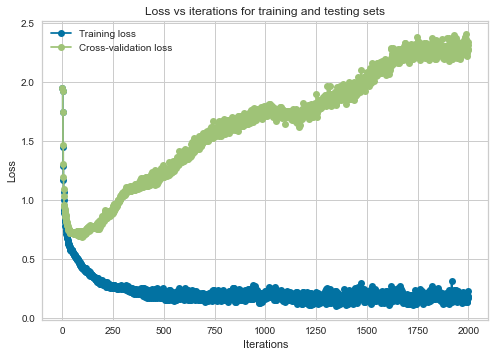

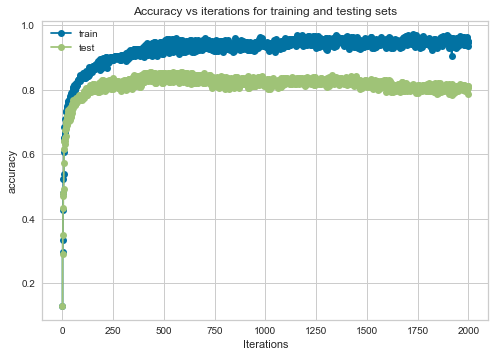

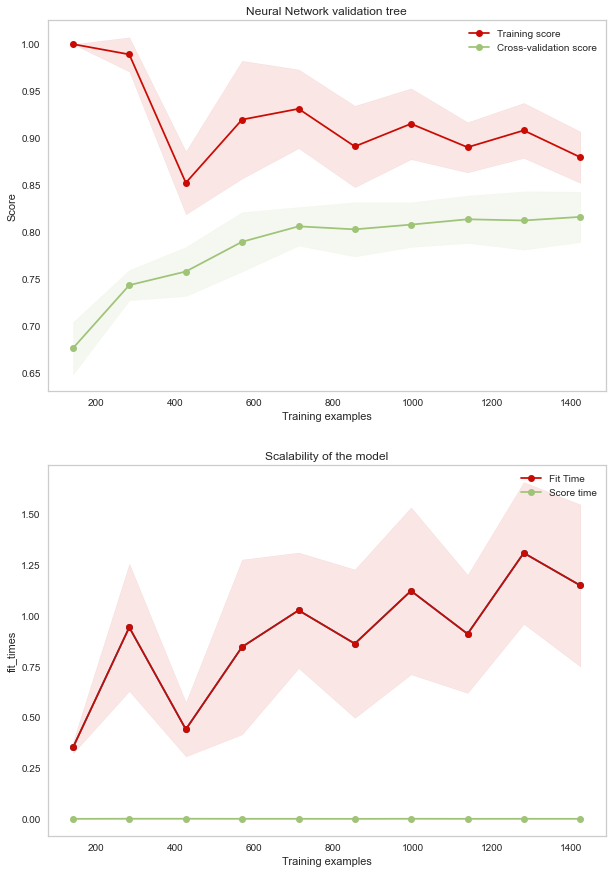

Accuracy score:  0.8049242424242424


In [18]:
problem4(X_train_2, X_test_2, Y_train_2, Y_test_2)

With Kmeans and NN


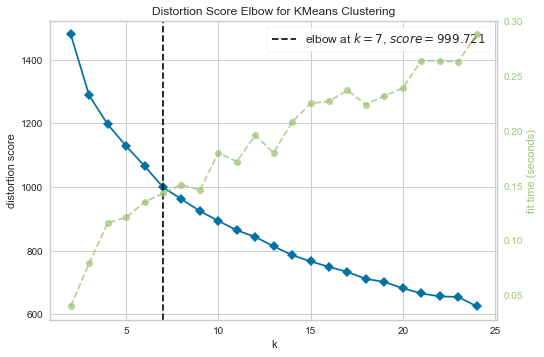

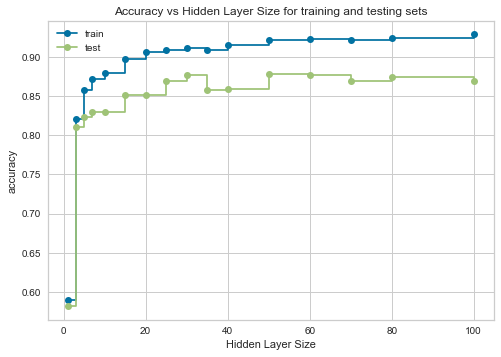

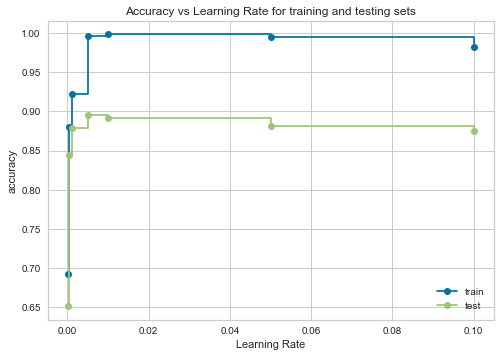

Hidden layer size: 50, Learning Rate: 0.01


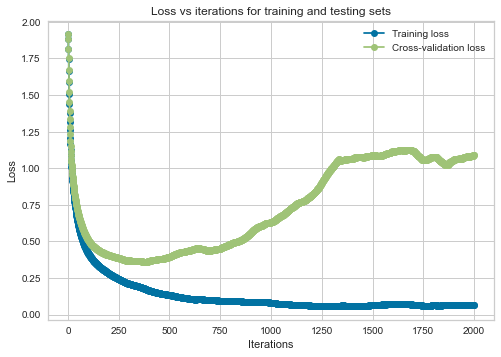

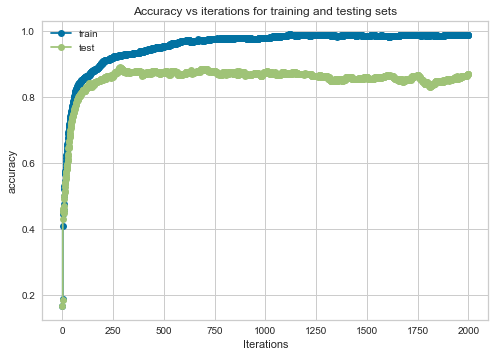

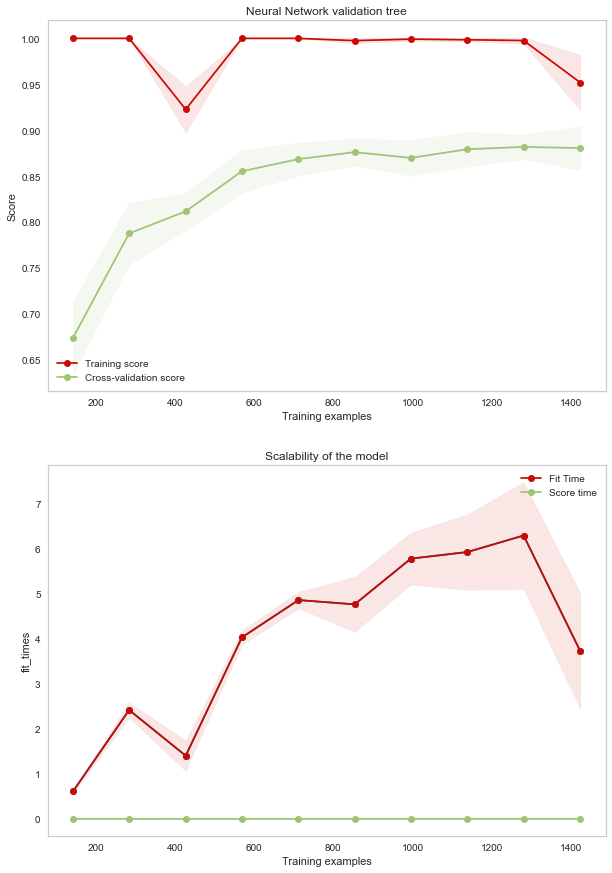

Accuracy score:  0.8920454545454546
With EM and NN


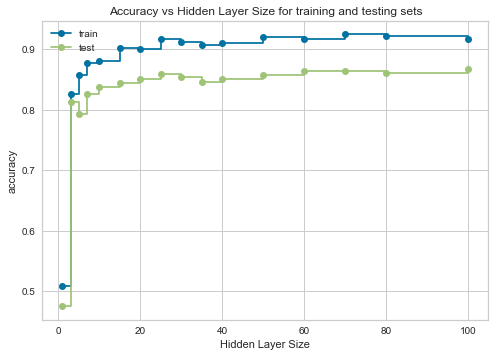

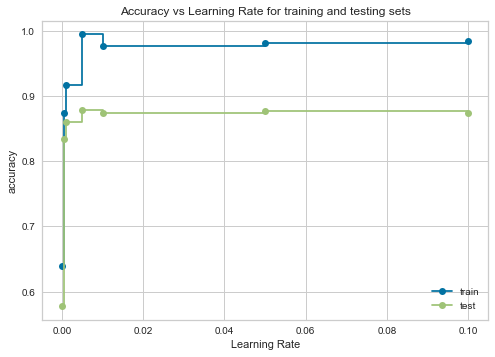

Hidden layer size: 25, Learning Rate: 0.01


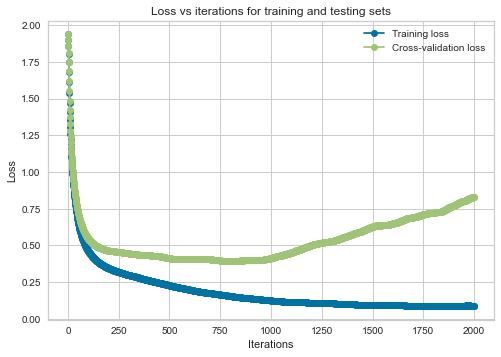

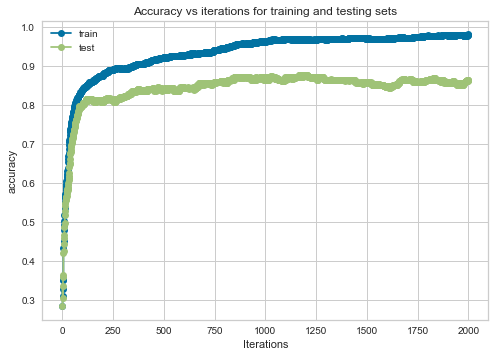

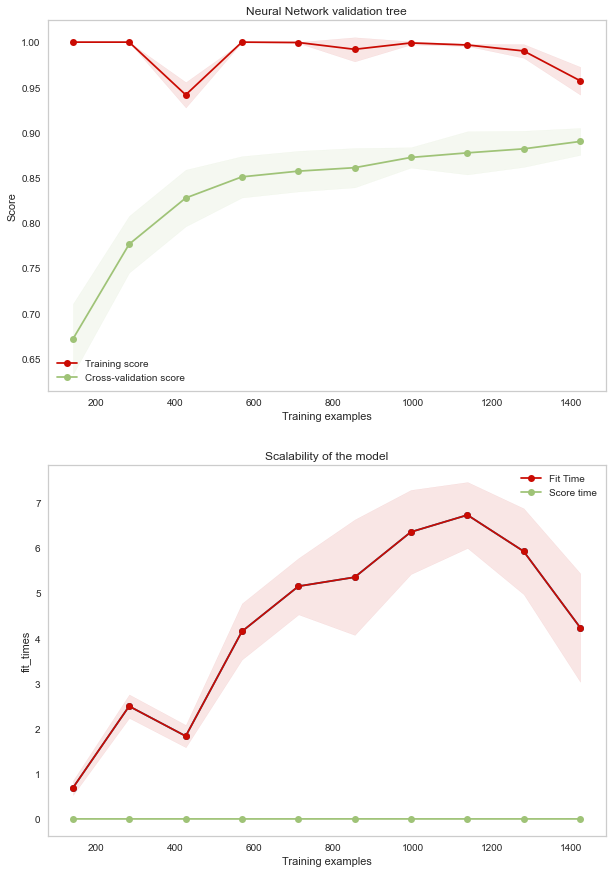

Accuracy score:  0.8731060606060606


In [19]:
problem5(X_train_2, X_test_2, Y_train_2, Y_test_2, 100)

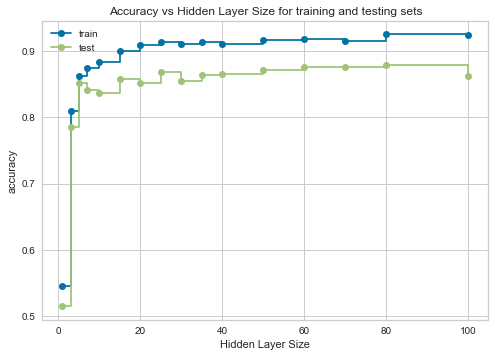

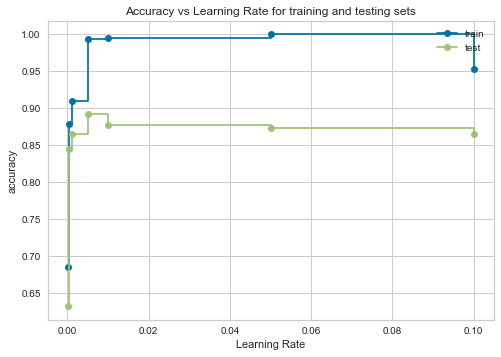

Hidden layer size: 40, Learning Rate: 0.01


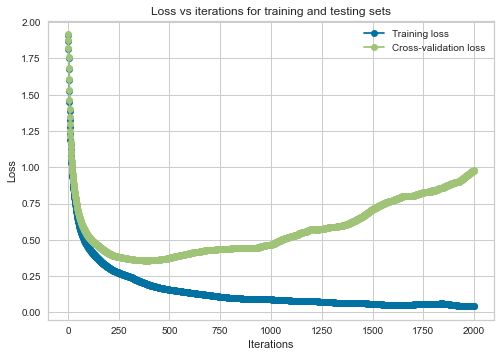

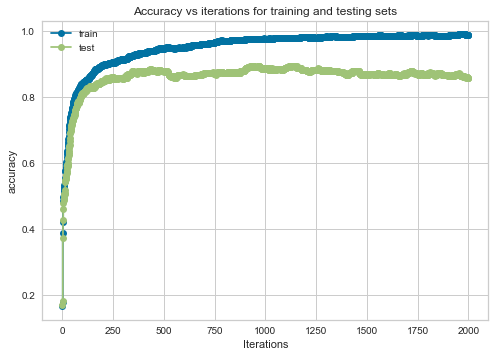

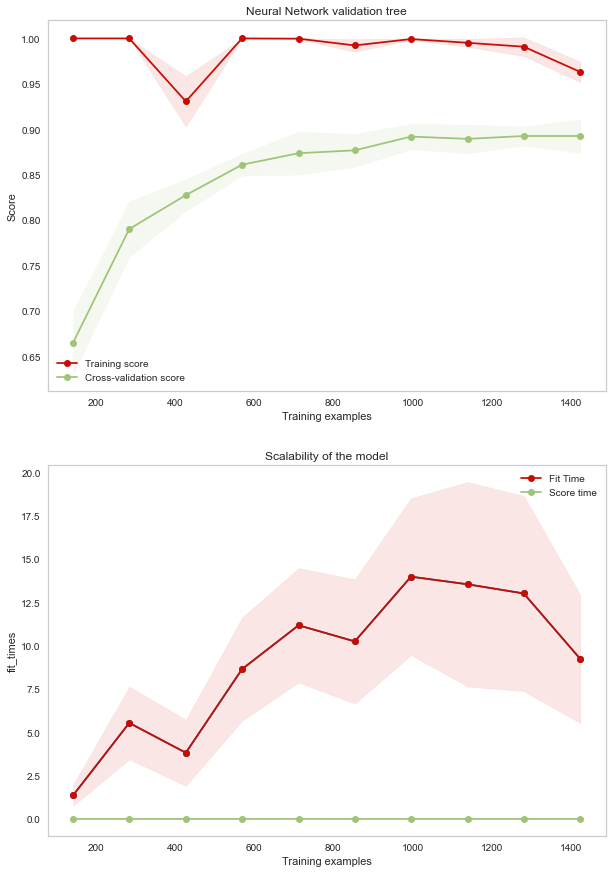

Accuracy score:  0.8768939393939394


In [20]:
classify_neural_network(X_train_2, X_test_2, Y_train_2, Y_test_2)